In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import ast


# Scikit-learn imports
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Установка стиля графиков
%matplotlib inline
sns.set(style='whitegrid')

# Установка seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Проект по Прогнозированию Цен Недвижимости

## Краткое Описание Проекта

Цель данного проекта — разработка модели машинного обучения для прогнозирования цен на недвижимость на основе различных характеристик объектов. Проект включает в себя полный цикл анализа данных: от предварительной обработки и разведочного анализа данных (EDA) до построения, обучения и оценки моделей машинного обучения. Основная задача состоит в создании точной и надежной модели, способной предсказывать стоимость домов с учетом их параметров.

## Основные Цели и Задачи
Анализ и Предварительная Обработка Данных:
Обработка пропущенных значений и аномалий.

Кодирование категориальных признаков с высокой и низкой кардинальностью.
Масштабирование числовых признаков для улучшения качества моделей.
Разведочный Анализ Данных (EDA):

Визуализация распределений признаков и целевой переменной.
Выявление и обработка выбросов.
Анализ корреляций между признаками и целевой переменной.
Построение Моделей Машинного Обучения:

Обучение и оценка различных регрессионных моделей (например, линейная регрессия, случайный лес, градиентный бустинг).
Настройка гиперпараметров для повышения точности моделей.
Отбор наиболее значимых признаков для оптимизации моделей.
Оценка и Визуализация Результатов:

Сравнение производительности моделей с использованием метрик MSE и R².
Визуализация фактических и предсказанных значений.
Анализ важности признаков для понимания вклада каждого параметра в модель.
Краткая Информация о Данных
В проекте использовался набор данных, содержащий информацию о различных характеристиках объектов недвижимости. Основные признаки включают:

Числовые Признаки:

baths — количество ванных комнат.
sqft — общая площадь дома (в квадратных футах).
beds — количество спален.
stories — количество этажей.
year_built — год постройки.
lotsize — размер участка (в акрах).
Категориальные Признаки:

propertytype_freq — частотное кодирование типа недвижимости.
Целевая Переменная:

target — цена недвижимости.

## 1. Загрузка и первичный анализ данных

In [3]:
# Загрузка данных
df = pd.read_csv('data2.csv')

# Копия исходного датафрейма для резервного сохранения
df_original = df.copy()

# Первичный анализ
print("Первые пять строк набора данных:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

print("\nОписание числовых признаков:")
print(df.describe())


Первые пять строк набора данных:
     status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating'

### Анализ и рекомендации по очистке данных

1. **Проблемы с типами данных**  
   В столбцах вроде `baths`, `beds` и `sqft` наблюдается разнородность форматов данных. Например, количество ванных комнат может быть записано как число (3.5) или как строка ('3 Baths'), что затрудняет преобразование этих признаков в числовой формат. `beds` также содержит смешение форматов (например, 4 и '3 Beds'). `sqft` представлен в разных форматах, включая строку с разделителями тысяч ('1,947 sqft').

   **Рекомендация**: Преобразовать все числовые признаки в единый формат. Для `baths` и `beds` можно удалить текстовую часть и оставить только число. Для `sqft` также нужно удалить текстовые обозначения и разделители тысяч, чтобы преобразовать значение в числовой тип.

2. **Пропущенные значения**  
   Во многих столбцах, таких как `private pool`, `fireplace`, `stories`, `PrivatePool`, `mls-id`, и `MlsId`, присутствует значительное количество пропусков. Это может существенно повлиять на качество модели, если не будет должным образом обработано.

   **Рекомендация**: Рассмотреть стратегии для обработки пропусков, такие как заполнение медианой, средним, модой или даже использование предсказательных моделей для заполнения пропусков. В случаях, когда пропуски встречаются редко, можно рассмотреть вариант удаления таких записей.

3. **Сложные данные в столбцах `homeFacts` и `schools`**  
   Данные в этих столбцах представлены в виде строк, которые содержат вложенные структуры, такие как словари или списки. Это затрудняет анализ и использование данных напрямую.

   **Рекомендация**: Десериализовать строки в Python-объекты (например, словари или списки) и извлечь полезные признаки. Для `homeFacts` можно выделить такие параметры, как возраст дома или наличие бассейна. Из `schools` можно извлечь информацию о рейтингах школ, что может стать важным фактором для оценки стоимости недвижимости.





In [4]:
print("Примеры значений в 'baths':")
print(df['baths'].head(10).tolist())

print("\nПримеры значений в 'beds':")
print(df['beds'].head(10).tolist())

print("\nПримеры значений в 'sqft':")
print(df['sqft'].head(10).tolist())

print("\nПримеры значений в 'stories':")
print(df['stories'].head(10).tolist())

print("\nПримеры значений в 'homefacts':")
print(df['homeFacts'].head(10).tolist())


Примеры значений в 'baths':
['3.5', '3 Baths', '2 Baths', '8 Baths', nan, nan, nan, nan, '2', '3']

Примеры значений в 'beds':
['4', '3 Beds', '3 Beds', '5 Beds', nan, '2 Beds', nan, nan, '3', '3']

Примеры значений в 'sqft':
['2900', '1,947 sqft', '3,000 sqft', '6,457 sqft', nan, '897 sqft', '1,507', nan, '3588', '1,930']

Примеры значений в 'stories':
[nan, '2.0', '1.0', '3.0', nan, '2.0', 'One', nan, nan, '2.0']

Примеры значений в 'homefacts':
["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}", "{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue':

## 2. Очистка и преобразование данных
2.1. Очистка числовых столбцов

In [5]:
unique_baths = df['baths'].unique()
print(unique_baths)


['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba'
 '3.5 ba' '0' '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0'
 '12 Baths' '5.5' '3,500' '1.5 Baths' '2,750' 'Bathrooms: 6' '4.5 Baths'
 '750' '5.5+' '6' '10 Baths' '6 ba' 'Bathrooms: 19' '10.0' '1.5 ba' '4 ba'
 '12 ba' '2.5+' '8' '7.5+' 'Bathrooms: 10' '0 / 0' 'Sq. Ft. ' '5 ba'
 '4.5+' '18 Baths' '-- baths' 'Bathrooms: 7' '7' '18' '3.5+' '1.5+'
 '11 Baths' '5,000' '1.75 Baths' '9' '12.0' '1.1 Baths' '6.5'
 'Bathrooms: 8' '10' '19 Baths' 'Bathrooms: 9' '16 Baths' '13 Baths'
 'Bathrooms: 13' '14' '9.0' '8.5+' '7 ba' '12' '2.5 ba' 'Bathrooms: 12'
 '17' 'Bathrooms: 241' '16.0' '10.5+' '8 ba' '6.5+' '6.5 Baths' '14 Baths'
 '7,500+' '7.5' '11.0'

In [6]:
def clean_baths(s):
    if pd.isnull(s):
        return np.nan
    else:
        original_s = s
        s = str(s).strip().lower()
        if s in ['--', '~', '—', 'n/a', 'na', '', 'none']:
            return np.nan
        # Удаляем запятые (разделители тысяч)
        s = s.replace(',', '')
        # Удаляем все, кроме цифр и точки
        s = re.sub(r'[^0-9\.]', '', s)
        s = s.strip()
        if s == '':
            print(f"Не удалось преобразовать '{original_s}' после очистки '{s}'")
            return np.nan
        try:
            baths = float(s)
            if 0 < baths < 50:
                return baths
            else:
                # Фильтруем нереалистичные значения
                return np.nan
        except ValueError:
            print(f"Не удалось преобразовать '{original_s}' после очистки '{s}'")
            return np.nan




In [7]:
def clean_beds(s):
    if pd.isnull(s):
        return np.nan
    else:
        original_s = s
        s = str(s).strip().lower()
        s = s.replace(',', '.')
        s = re.sub(r'[^0-9\.]', '', s)
        s = s.strip()
        try:
            beds = float(s)
            if 0 <= beds < 50:  # Расширяем диапазон
                return beds
            else:
                return np.nan
        except ValueError:
            print(f"Не удалось преобразовать '{original_s}' после очистки '{s}'")
            return np.nan


In [8]:
def clean_sqft(s):
    if pd.isnull(s):
        return np.nan
    else:
        original_s = s
        s = str(s).lower()
        s = s.replace(',', '')
        s = re.sub(r'[^0-9\.]', '', s)
        s = s.strip()
        try:
            sqft = float(s)
            if sqft > 0:
                return sqft
            else:
                return np.nan
        except ValueError:
            print(f"Не удалось преобразовать '{original_s}' после очистки '{s}'")
            return np.nan


In [9]:
text_num_map = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five':5,
    'six':6,
    'seven':7,
    'eight':8,
    'nine':9,
    'ten':10,
    'zero':0,
    'single': 1,
    'double': 2,
    'triple': 3
}

def clean_stories(s):
    if pd.isnull(s):
        return np.nan
    else:
        original_s = s
        s = str(s).lower()
        s = s.replace(',', '').strip()
        # Преобразуем текстовые числа в цифры
        for word, num in text_num_map.items():
            if word in s:
                return num
        # Удаляем все, кроме цифр и точки
        s = re.sub(r'[^0-9\.]', '', s)
        s = s.strip()
        try:
            stories = float(s)
            if 0 <= stories < 50:
                return stories
            else:
                return np.nan
        except ValueError:
            print(f"Не удалось преобразовать '{original_s}' после очистки '{s}'")
            return np.nan


In [10]:
# Функция для извлечения 'year_built' из столбца 'homeFacts'
def extract_year_built(s):
    if pd.isnull(s):
        return np.nan
    else:
        try:
            # Преобразуем строку в словарь
            s_corrected = s.replace('null', 'None').replace('true', 'True').replace('false', 'False')
            data = ast.literal_eval(s_corrected)
            # Проверяем наличие ключа 'atAGlanceFacts' с учетом регистра
            if 'atAGlanceFacts' in data:
                facts = data['atAGlanceFacts']
                for item in facts:
                    fact_label = item.get('factLabel', '')
                    fact_value = item.get('factValue', '')
                    if fact_label and fact_label.strip().lower() == 'year built':
                        if fact_value is not None:
                            year = str(fact_value).strip()
                            # Удаляем все, кроме цифр
                            year_cleaned = re.sub(r'[^0-9]', '', year)
                            if year_cleaned.isdigit():
                                year_int = int(year_cleaned)
                                if 1800 <= year_int <= 2023:
                                    return year_int
            return np.nan
        except (ValueError, SyntaxError, AttributeError) as e:
            # print(f"Ошибка при обработке 'homeFacts': {e}")
            return np.nan

# Применяем функцию к столбцу 'homeFacts' (с заглавной буквой 'F')
df['year_built'] = df['homeFacts'].apply(extract_year_built)

# Проверяем результаты
print("Количество непустых значений в 'year_built':", df['year_built'].notnull().sum())

# Выводим несколько примеров
print(df[['homeFacts', 'year_built']].head(10))




Количество непустых значений в 'year_built': 313558
                                           homeFacts  year_built
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...      2019.0
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...      2019.0
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...      1961.0
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...      2006.0
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...         NaN
5  {'atAGlanceFacts': [{'factValue': '1920', 'fac...      1920.0
6  {'atAGlanceFacts': [{'factValue': '2006', 'fac...      2006.0
7  {'atAGlanceFacts': [{'factValue': '1976', 'fac...      1976.0
8  {'atAGlanceFacts': [{'factValue': '1970', 'fac...      1970.0
9  {'atAGlanceFacts': [{'factValue': '2019', 'fac...      2019.0


In [11]:
numerical_columns = ['baths', 'beds', 'sqft', 'stories', 'year_built']
for col in numerical_columns:
    print(f"Количество непустых значений в '{col}': {df[col].notnull().sum()}")


Количество непустых значений в 'baths': 270847
Количество непустых значений в 'beds': 285903
Количество непустых значений в 'sqft': 336608
Количество непустых значений в 'stories': 226470
Количество непустых значений в 'year_built': 313558


In [12]:
print("\nСтатистика числовых столбцов после очистки:")
print(df[numerical_columns].describe())




Статистика числовых столбцов после очистки:
          year_built
count  313558.000000
mean     1979.267290
std        33.578825
min      1800.000000
25%      1956.000000
50%      1985.000000
75%      2007.000000
max      2022.000000


In [13]:
df['baths'] = df['baths'].apply(clean_baths)
df['beds'] = df['beds'].apply(clean_beds)
df['sqft'] = df['sqft'].apply(clean_sqft)
df['stories'] = df['stories'].apply(clean_stories)
df['year_built'] = df['homeFacts'].apply(extract_year_built)

Не удалось преобразовать 'Sq. Ft. ' после очистки '..'
Не удалось преобразовать 'Sq. Ft. ' после очистки '..'
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать 'Sq. Ft. ' после очистки '..'
Не удалось преобразовать '-- baths' после очистки ''
Не удалось преобразовать 'Sq. Ft. ' после очистки '..'
Не удалось преобразовать '-- baths' по

In [14]:
df['baths'] = df['baths'].astype(float)
df['beds'] = df['beds'].astype(float)
df['sqft'] = df['sqft'].astype(float)
df['stories'] = df['stories'].astype(float)
df['year_built'] = df['year_built'].astype('Int64')

In [15]:
# Удаление выбросов в 'baths' и 'beds'
df = df[(df['baths'] <= 10) & (df['beds'] <= 10)]

# Удаление выбросов в 'sqft'
df = df[df['sqft'] <= 20000]

# Удаление выбросов в 'stories'
df = df[df['stories'] <= 5]

# Удаление записей с нулевыми значениями в 'beds' и 'baths'
df = df[(df['beds'] > 0) & (df['baths'] > 0)]

# Повторная проверка статистики
numerical_columns = ['baths', 'beds', 'sqft', 'stories', 'year_built']
print("\nСтатистика числовых столбцов после удаления выбросов:")
print(df[numerical_columns].describe())




Статистика числовых столбцов после удаления выбросов:
               baths           beds           sqft        stories   year_built
count  180083.000000  180083.000000  180083.000000  180083.000000     168146.0
mean        2.788486       3.427842    2288.904005       1.545458  1981.745097
std         1.214808       1.081350    1318.743593       0.803995    32.353992
min         0.750000       1.000000       1.000000       0.000000       1800.0
25%         2.000000       3.000000    1458.000000       1.000000       1960.0
50%         2.500000       3.000000    1974.000000       1.000000       1989.0
75%         3.000000       4.000000    2721.000000       2.000000       2007.0
max        10.000000      10.000000   20000.000000       5.000000       2020.0


In [16]:
df['baths'] = df['baths'].apply(clean_baths)
df['beds'] = df['beds'].apply(clean_beds)
df['sqft'] = df['sqft'].apply(clean_sqft)
df['stories'] = df['stories'].apply(clean_stories)
df['year_built'] = df['homeFacts'].apply(extract_year_built)

In [17]:
print("\nСтатистика числовых столбцов после очистки:")
print(df[numerical_columns].describe())


Статистика числовых столбцов после очистки:
               baths           beds           sqft        stories  \
count  180083.000000  180083.000000  180083.000000  180083.000000   
mean        2.788486       3.427842    2288.904005       1.545458   
std         1.214808       1.081350    1318.743593       0.803995   
min         0.750000       1.000000       1.000000       0.000000   
25%         2.000000       3.000000    1458.000000       1.000000   
50%         2.500000       3.000000    1974.000000       1.000000   
75%         3.000000       4.000000    2721.000000       2.000000   
max        10.000000      10.000000   20000.000000       5.000000   

          year_built  
count  168146.000000  
mean     1981.745097  
std        32.353992  
min      1800.000000  
25%      1960.000000  
50%      1989.000000  
75%      2007.000000  
max      2020.000000  


## 1. Столбец 'baths' (Количество ванных комнат)
Количество записей (count): 180,083
Среднее значение (mean): ~2.79
Стандартное отклонение (std): ~1.21
Минимум (min): 0.75
Максимум (max): 10.0
Замечания:

Среднее значение в 2.79 указывает на то, что в среднем дома имеют около 2-3 ванных комнат, что является типичным для жилых домов.
Минимальное значение в 0.75 может соответствовать трёхчетвертной ванной комнате (умывальник, туалет и душ, без ванны).
Максимальное значение в 10 ванных комнат выглядит разумным после удаления выбросов.
## 2. Столбец 'beds' (Количество спален)
Количество записей: 180,083
Среднее значение: ~3.43
Стандартное отклонение: ~1.08
Минимум: 1.0
Максимум: 10.0
Замечания:

Среднее значение в 3.43 означает, что в среднем дома имеют 3-4 спальни.
Минимальное значение в 1 спальню соответствует однокомнатным квартирам или небольшим домам.
Максимальное значение в 10 спален также выглядит приемлемо после удаления выбросов.
## 3. Столбец 'sqft' (Площадь в квадратных футах)
Количество записей: 180,083
Среднее значение: ~2,289 sqft
Стандартное отклонение: ~1,319 sqft
Минимум: 1 sqft
Максимум: 20,000 sqft
Замечания:

Среднее значение в 2,289 sqft (около 213 кв.м) соответствует типичной жилой недвижимости.
Минимальное значение в 1 sqft, вероятно, является ошибкой. Рекомендуется проверить и, возможно, удалить такие записи.
Максимальное значение в 20,000 sqft (около 1,858 кв.м) может соответствовать большим особнякам или коммерческой недвижимости.
## 4. Столбец 'stories' (Количество этажей)
Количество записей: 180,083
Среднее значение: ~1.55
Стандартное отклонение: ~0.80
Минимум: 0.0
Максимум: 5.0
Замечания:

Среднее значение около 1.55 этажей указывает на то, что большинство домов имеют 1-2 этажа.
Минимальное значение в 0 этажей может быть ошибкой данных. Рассмотрите возможность удаления или корректировки таких записей.
Максимальное значение в 5 этажей соответствует многоэтажным жилым зданиям или таунхаусам.
## 5. Столбец 'year_built' (Год постройки)
Количество записей: 168,146
Среднее значение: ~1981.75
Стандартное отклонение: ~32.35
Минимум: 1800
Максимум: 2020
Замечания:

Средний год постройки — 1981, что говорит о преобладании относительно новых домов в данных.
Минимальное значение в 1800 год может относиться к историческим зданиям. Возможно, стоит проверить корректность этих данных.
Максимальное значение в 2020 год соответствует недавно построенной недвижимости.

## 2.2. Обработка столбца homeFacts
Проблема:

homeFacts содержит данные в виде строк, представляющих собой JSON-объекты. Необходимо извлечь полезную информацию, такую как год постройки, размер участка и т.д.



In [18]:
def extract_home_facts(home_facts):
    try:
        # Преобразуем строку в словарь
        facts = ast.literal_eval(home_facts)
        # Извлекаем 'atAGlanceFacts'
        at_a_glance = facts.get('atAGlanceFacts', [])
        # Создаем словарь с factLabel как ключом и factValue как значением
        fact_dict = {item.get('factLabel'): item.get('factValue') for item in at_a_glance if 'factLabel' in item and 'factValue' in item}
        return pd.Series(fact_dict)
    except (ValueError, SyntaxError, TypeError) as e:
        # Для отладки можно временно раскомментировать следующую строку
        # print(f"Ошибка при обработке 'home_facts': {e} | Data: {home_facts}")
        return pd.Series()

# Проверка наличия столбца 'homeFacts'
if 'homeFacts' in df.columns:
    # Применение функции к столбцу
    home_facts_df = df['homeFacts'].apply(extract_home_facts)
    
    # Объединение с основным DataFrame
    df = pd.concat([df.drop(columns=['homeFacts']), home_facts_df], axis=1)
    print("Обработка столбца 'homeFacts' завершена успешно.")
else:
    print("Столбец 'homeFacts' отсутствует в DataFrame.")
    
# Очистка новых столбцов
numeric_home_facts = ['Year built', 'Remodeled year', 'lotsize', 'Price/sqft']
for col in numeric_home_facts:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('[\$,]', '', regex=True)
        df[col] = df[col].astype(str).str.replace(' sqft', '', regex=False)
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Столбец '{col}' очищен и преобразован в числовой тип.")


Обработка столбца 'homeFacts' завершена успешно.
Столбец 'Year built' очищен и преобразован в числовой тип.
Столбец 'Remodeled year' очищен и преобразован в числовой тип.
Столбец 'lotsize' очищен и преобразован в числовой тип.
Столбец 'Price/sqft' очищен и преобразован в числовой тип.


Обработали комплексную информацию о недвижимости, извлекли и распаковали дополнительные признаки, расширив набор данных.

In [19]:
print(df.columns.tolist())


['status', 'private pool', 'propertyType', 'street', 'baths', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds', 'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target', 'year_built', 'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']


## 2.3. Обработка столбца schools
Проблема:

schools содержит информацию о школах в виде сложных строк (JSON-подобных). Нужно извлечь рейтинги школ и расстояния до них.

Что делать:

Десериализовать данные.
Извлечь средний рейтинг школ и минимальное расстояние до школы.
Добавить их как новые признаки.

In [20]:
def extract_school_info(schools_info):
    try:
        # Преобразуем строку в словарь
        schools = ast.literal_eval(schools_info)
        ratings = []
        distances = []
        
        # Извлечение рейтингов
        if 'rating' in schools and isinstance(schools['rating'], list):
            for r in schools['rating']:
                if isinstance(r, str):
                    if '/' in r:
                        rating_str = r.split('/')[0]
                        if rating_str.replace('.', '', 1).isdigit():
                            ratings.append(float(rating_str))
                    elif r.replace('.', '', 1).isdigit():
                        ratings.append(float(r))
                elif isinstance(r, (int, float)):
                    ratings.append(float(r))
        
        # Извлечение расстояний
        if 'data' in schools and 'Distance' in schools['data'] and isinstance(schools['data']['Distance'], list):
            for d in schools['data']['Distance']:
                if isinstance(d, str):
                    distance_str = d.replace('mi', '').strip()
                    if distance_str.replace('.', '', 1).isdigit():
                        distances.append(float(distance_str))
        
        avg_rating = np.mean(ratings) if ratings else np.nan
        min_distance = np.min(distances) if distances else np.nan
        return pd.Series({'avg_school_rating': avg_rating, 'min_school_distance': min_distance})
    
    except (ValueError, SyntaxError, TypeError, KeyError) as e:
        # Для отладки можно временно раскомментировать следующую строку
        # print(f"Ошибка при обработке 'schools_info': {e} | Data: {schools_info}")
        return pd.Series({'avg_school_rating': np.nan, 'min_school_distance': np.nan})

# Проверка наличия столбца 'schools'
if 'schools' in df.columns:
    # Применение функции
    school_info_df = df['schools'].apply(extract_school_info)
    
    # Объединение с основным DataFrame
    df = pd.concat([df.drop(columns=['schools']), school_info_df], axis=1)
    print("Обработка столбца 'schools' завершена успешно.")
else:
    print("Столбец 'schools' отсутствует в DataFrame. Пропускаем шаг 2.3.")



Обработка столбца 'schools' завершена успешно.


Удалили дубликаты, привели типы данных к корректному формату, подготовили данные для последующих шагов.

## 2.4. Обработка пропущенных значений
Проблема:

В данных есть пропуски, которые могут повлиять на качество модели.

Что делать:

Проверить количество пропусков в каждом столбце.
Принять решение: удалить столбцы/строки с большим количеством пропусков или заполнить их.

In [21]:
from collections import Counter

# 1. Стандартизация имен столбцов
# Преобразуем все имена столбцов в нижний регистр и заменим пробелы, дефисы, слеши на подчеркивания
df.columns = (
    df.columns
    .str.lower()
    .str.replace(' ', '_', regex=True)
    .str.replace('-', '_', regex=True)
    .str.replace('/', '_', regex=True)
    .str.replace("'", "", regex=True)
    .str.replace('"', "", regex=True)
)

print("Новые имена столбцов:")
print(df.columns.tolist())

# 2. Проверка и удаление дублирующих столбцов
duplicated_columns = df.columns[df.columns.duplicated()].unique()
if len(duplicated_columns) > 0:
    print("Дублирующиеся столбцы:", duplicated_columns)
    # Удаление дублирующихся столбцов, оставляя первый экземпляр
    df = df.loc[:, ~df.columns.duplicated()]
    print("Дублирующие столбцы удалены.")
else:
    print("Дублирующих столбцов не найдено.")

# 3. Проверка и корректировка типов данных столбцов
print("\nТипы данных столбцов до преобразования:")
print(df.dtypes)

# Определение числовых столбцов для преобразования
numeric_columns = ['baths', 'beds', 'sqft', 'stories', 'year_built', 
                   'remodeled_year', 'lotsize', 'price_sqft', 
                   'avg_school_rating', 'min_school_distance']

# Преобразование указанных столбцов в числовой тип данных
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Столбец '{col}' преобразован в числовой тип.")

print("\nТипы данных столбцов после преобразования:")
print(df.dtypes)

# 4. Проверка пропущенных значений
print("\nПропущенные значения в каждом столбце:")
print(df.isnull().sum())

# 5. Удаление столбцов с большим количеством пропусков (более 50%)
threshold_col = 0.5 * len(df)  # Порог: 50% заполненных значений
cols_before = df.shape[1]
df = df.dropna(thresh=threshold_col, axis=1)
cols_after = df.shape[1]
print(f"Удалено {cols_before - cols_after} столбцов с менее чем 50% заполненных значений.")

# 6. Определение числовых и категориальных столбцов после удаления
numerical_cols = ['baths', 'beds', 'sqft', 'stories', 'year_built', 
                 'remodeled_year', 'lotsize', 'price_sqft', 
                 'avg_school_rating', 'min_school_distance']

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nКатегориальные столбцы для заполнения пропусков:", categorical_cols)

# 7. Заполнение пропусков в числовых столбцах медианой
for col in numerical_cols:
    if col in df.columns:
        missing = df[col].isnull().sum()
        if missing > 0:
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
            print(f"Пропущенные значения в числовом столбце '{col}' заполнены медианой: {median_value}")

# 8. Заполнение пропусков в категориальных столбцах модой
for col in categorical_cols:
    if col in df.columns:
        missing = df[col].isnull().sum()
        if missing > 0:
            mode_value = df[col].mode()
            if not mode_value.empty:
                mode_val = mode_value[0]
                df[col] = df[col].fillna(mode_val)
                print(f"Пропущенные значения в категориальном столбце '{col}' заполнены модой: {mode_val}")
            else:
        
                df[col] = df[col].fillna('Unknown')
                print(f"Пропущенные значения в категориальном столбце '{col}' заполнены значением 'Unknown'.")

# 9. Обработка целевой переменной 'target'
if 'target' in df.columns:
    # Проверка типа данных целевой переменной
    print(f"\nТип данных 'target' перед преобразованием: {df['target'].dtype}")
    
    if df['target'].dtype == 'object':
        # Удаление символов '$' и ',' из строковых значений
        df['target'] = df['target'].str.replace('[\$,]', '', regex=True)
        # Преобразование в числовой тип данных
        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        print("Столбец 'target' преобразован в числовой тип.")
        
        # Проверка и заполнение пропусков в 'target'
        missing_target = df['target'].isnull().sum()
        if missing_target > 0:
            median_target = df['target'].median()
            df['target'] = df['target'].fillna(median_target)
            print(f"Пропущенные значения в 'target' заполнены медианой: {median_target}")
        
        # Удаление строк с пропущенными значениями в 'target' 
        initial_rows = df.shape[0]
        df = df.dropna(subset=['target'])
        final_rows = df.shape[0]
        print(f"Удалено {initial_rows - final_rows} строк с пропущенными значениями в 'target'.")
    else:
        # Если 'target' уже числовой, просто удаляем строки с пропусками
        initial_rows = df.shape[0]
        df = df.dropna(subset=['target'])
        final_rows = df.shape[0]
        print(f"Удалено {initial_rows - final_rows} строк с пропущенными значениями в 'target'.")
else:
    print("Столбец 'target' отсутствует в DataFrame.")

# 10. Проверка пропусков после заполнения
print("\nПропущенные значения после заполнения:")
print(df.isnull().sum())

# 11. Дополнительная обработка оставшихся пропусков 
# Определение столбцов с оставшимися пропусками
cols_with_missing = df.columns[df.isnull().any()].tolist()
print("\nСтолбцы с оставшимися пропусками:", cols_with_missing)

# Решение: заполнение или удаление оставшихся пропусков
for col in cols_with_missing:
    if col in numerical_cols:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)
        print(f"Пропущенные значения в числовом столбце '{col}' заполнены медианой: {median_value}")
    elif col in categorical_cols:
        mode_value = df[col].mode()
        if not mode_value.empty:
            mode_val = mode_value[0]
            df[col] = df[col].fillna(mode_val)
            print(f"Пропущенные значения в категориальном столбце '{col}' заполнены модой: {mode_val}")
        else:
            df[col] = df[col].fillna('Unknown')
            print(f"Пропущенные значения в категориальном столбце '{col}' заполнены значением 'Unknown'.")

# Финальная проверка пропусков
print("\nФинальное количество пропусков в каждом столбце:")
print(df.isnull().sum())






Новые имена столбцов:
['status', 'private_pool', 'propertytype', 'street', 'baths', 'fireplace', 'city', 'sqft', 'zipcode', 'beds', 'state', 'stories', 'mls_id', 'privatepool', 'mlsid', 'target', 'year_built', 'year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize', 'price_sqft', 'avg_school_rating', 'min_school_distance']
Дублирующиеся столбцы: Index(['year_built'], dtype='object')
Дублирующие столбцы удалены.

Типы данных столбцов до преобразования:
status                  object
private_pool            object
propertytype            object
street                  object
baths                  float64
fireplace               object
city                    object
sqft                   float64
zipcode                 object
beds                   float64
state                   object
stories                float64
mls_id                  object
privatepool             object
mlsid                   object
target                  object
year_built             float6

Заполнили пропуски в числовых и категориальных признаках, удалили строки с пропущенными целевыми значениями, обеспечив полноту данных для обучения моделей.

## Шаг 2.5: Обновление списков признаков

In [22]:
from collections import Counter

# 1. Стандартизация имен столбцов
df.columns = (
    df.columns
    .str.lower()
    .str.replace(' ', '_', regex=True)
    .str.replace('-', '_', regex=True)
    .str.replace('/', '_', regex=True)
    .str.replace("'", "", regex=True)
    .str.replace('"', "", regex=True)
)

print("Новые имена столбцов:")
print(df.columns.tolist())

# 2. Проверка и удаление дублирующих столбцов
duplicated_columns = df.columns[df.columns.duplicated()].unique()
if len(duplicated_columns) > 0:
    print("Дублирующиеся столбцы:", duplicated_columns)
    # Удаление дублирующихся столбцов, оставляя первый экземпляр
    df = df.loc[:, ~df.columns.duplicated()]
    print("Дублирующие столбцы удалены.")
else:
    print("Дублирующих столбцов не найдено.")

# 3. Проверка и корректировка типов данных столбцов
print("\nТипы данных столбцов до преобразования:")
print(df.dtypes)

# Определение числовых столбцов для преобразования
numerical_cols = ['baths', 'beds', 'sqft', 'stories', 'year_built', 'lotsize']

# Преобразование указанных столбцов в числовой тип данных
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Столбец '{col}' преобразован в числовой тип.")

print("\nТипы данных столбцов после преобразования:")
print(df.dtypes)

# 4. Проверка пропущенных значений
print("\nПропущенные значения в каждом столбце:")
print(df.isnull().sum())

# 5. Удаление столбцов с большим количеством пропусков (более 50%)
threshold_col = 0.5 * len(df)  # Порог: 50% заполненных значений
cols_before = df.shape[1]
df = df.dropna(thresh=threshold_col, axis=1)
cols_after = df.shape[1]
print(f"Удалено {cols_before - cols_after} столбцов с менее чем 50% заполненных значений.")

# 6. Удаление ненужных столбцов
drop_cols = ['mlsid', 'street', 'status']
df = df.drop(columns=drop_cols, errors='ignore')
print("Ненужные столбцы удалены:", drop_cols)

# 7. Обновление списков признаков
numerical_cols = ['baths', 'beds', 'sqft', 'stories', 'year_built', 'lotsize']
categorical_cols = ['propertytype', 'heating', 'cooling', 'parking', 'city', 'zipcode', 'state']

print("\nФинальный список числовых признаков:", numerical_cols)
print("Финальный список категориальных признаков:", categorical_cols)


Новые имена столбцов:
['status', 'propertytype', 'street', 'baths', 'city', 'sqft', 'zipcode', 'beds', 'state', 'stories', 'mlsid', 'target', 'year_built', 'heating', 'cooling', 'parking', 'lotsize']
Дублирующих столбцов не найдено.

Типы данных столбцов до преобразования:
status           object
propertytype     object
street           object
baths           float64
city             object
sqft            float64
zipcode          object
beds            float64
state            object
stories         float64
mlsid            object
target          float64
year_built      float64
heating          object
cooling          object
parking          object
lotsize         float64
dtype: object
Столбец 'baths' преобразован в числовой тип.
Столбец 'beds' преобразован в числовой тип.
Столбец 'sqft' преобразован в числовой тип.
Столбец 'stories' преобразован в числовой тип.
Столбец 'year_built' преобразован в числовой тип.
Столбец 'lotsize' преобразован в числовой тип.

Типы данных столбцов после

Определили и обновили списки числовых и категориальных признаков, удалили ненужные столбцы, подготовив данные для кодирования категориальных признаков и моделирования.

## Шаг 2.6: Кодирование категориальных признаков

In [23]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


# Обновлённый список категориальных признаков без 'propertytype', 'heating', 'cooling', 'parking'
categorical_cols = ['city', 'zipcode', 'state']

# 2.6.2: Анализ количества уникальных категорий
print("Анализ количества уникальных категорий в категориальных признаках:")
for col in categorical_cols:
    if col in df.columns:
        unique_values = df[col].nunique()
        print(f"Признак '{col}' имеет {unique_values} уникальных категорий.")
    else:
        print(f"Признак '{col}' отсутствует в DataFrame.")

# 2.6.3: Объединение Редких Категорий (если применимо)
from collections import Counter

def combine_rare_categories(df, column, threshold=50):
    counts = Counter(df[column])
    rare = [k for k, v in counts.items() if v < threshold]
    df[column] = df[column].replace(rare, 'Other')
    return df

# Применение функции к каждому признаку
for col in categorical_cols:
    if col in df.columns:
        df = combine_rare_categories(df, col, threshold=50)
        print(f"Редкие категории в '{col}' объединены.")

Анализ количества уникальных категорий в категориальных признаках:
Признак 'city' имеет 1452 уникальных категорий.
Признак 'zipcode' имеет 3837 уникальных категорий.
Признак 'state' имеет 32 уникальных категорий.
Редкие категории в 'city' объединены.
Редкие категории в 'zipcode' объединены.
Редкие категории в 'state' объединены.


## Шаг 2.6.4: Применение кодирования категориальных признаков

In [24]:
# 2.6.4.: Применение Target Encoding к признакам с высокой кардинальностью
high_cardinality_cols = ['city', 'zipcode', 'state']

# Проверка наличия признаков
high_cardinality_cols = [col for col in high_cardinality_cols if col in df.columns]

if high_cardinality_cols:
    try:
        te = TargetEncoder(cols=high_cardinality_cols)
        df[high_cardinality_cols] = te.fit_transform(df[high_cardinality_cols], df['target'])
        print("Target Encoding применён к признакам с высокой кардинальностью:", high_cardinality_cols)
    except AttributeError as e:
        print("Ошибка при применении Target Encoding:", e)
        print("Используем альтернативный метод Frequency Encoding.")
        
        # Альтернативный метод: Frequency Encoding
        def frequency_encoding(df, column):
            freq = df[column].value_counts(normalize=True)
            df[column + '_freq'] = df[column].map(freq)
            return df

        for col in high_cardinality_cols:
            df = frequency_encoding(df, col)
            print(f"Frequency Encoding применён к признаку '{col}'.")
            # При необходимости удалите оригинальный столбец
            df = df.drop(columns=[col])
            print(f"Оригинальный столбец '{col}' удалён после Frequency Encoding.")
else:
    print("Признаки для Target Encoding отсутствуют в DataFrame.")


Target Encoding применён к признакам с высокой кардинальностью: ['city', 'zipcode', 'state']


c:\Users\Константин\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


## Шаг 2.6.5 проверка DataFrame После Кодирования

In [25]:
# 2.6.5: Проверка DataFrame После Кодирования
print("\nПервые 5 строк DataFrame после кодирования категориальных признаков:")
print(df.head())

print("\nКоличество пропущенных значений в каждом столбце:")
print(df.isnull().sum())

print("\nТипы данных столбцов:")
print(df.dtypes)



Первые 5 строк DataFrame после кодирования категориальных признаков:
          propertytype  baths          city    sqft       zipcode  beds  \
1   single-family home    3.0  3.312946e+05  1947.0  6.179845e+05   3.0   
2   single-family home    2.0  2.568855e+06  3000.0  6.375769e+06   3.0   
3   single-family home    8.0  7.191128e+05  6457.0  2.916119e+06   5.0   
9        Single Family    3.0  5.235349e+05  1930.0  3.516647e+05   3.0   
12  single-family home    3.0  3.866164e+05  2839.0  6.179845e+05   4.0   

           state  stories     target  year_built     heating  cooling  \
1   6.339119e+05      2.0   310000.0      2019.0                        
2   1.208783e+06      1.0  2895000.0      1961.0  Forced Air  Central   
3   4.568471e+05      3.0  2395000.0      2006.0  Forced Air  Central   
9   4.568471e+05      2.0   311995.0      2019.0         Gas  Central   
12  5.642391e+05      1.0   525000.0      1996.0  Forced Air  Central   

                     parking  lotsize  


## Шаг 2.6.6: Масштабирование Числовых Признаков
Масштабирование числовых признаков приводит их к одному масштабу, что может улучшить производительность некоторых моделей машинного обучения.

StandardScaler стандартизирует признаки путем вычитания среднего и деления на стандартное отклонение.

In [26]:
# 2.6.6: Масштабирование Числовых Признаков
numerical_features = ['baths', 'beds', 'sqft', 'stories', 'year_built', 'lotsize']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
print("Масштабирование числовых признаков выполнено.")

# Проверка масштабирования
print("\nПервые 5 строк DataFrame после масштабирования числовых признаков:")
print(df.head())

print("\nСтатистические характеристики числовых признаков после масштабирования:")
print(df[numerical_features].describe())


Масштабирование числовых признаков выполнено.

Первые 5 строк DataFrame после масштабирования числовых признаков:
          propertytype     baths          city      sqft       zipcode  \
1   single-family home  0.174114  3.312946e+05 -0.259266  6.179845e+05   
2   single-family home -0.649064  2.568855e+06  0.539224  6.375769e+06   
3   single-family home  4.290003  7.191128e+05  3.160666  2.916119e+06   
9        Single Family  0.174114  5.235349e+05 -0.272157  3.516647e+05   
12  single-family home  0.174114  3.866164e+05  0.417138  6.179845e+05   

        beds         state   stories     target  year_built     heating  \
1  -0.395656  6.339119e+05  0.565356   310000.0    1.174316               
2  -0.395656  1.208783e+06 -0.678436  2895000.0   -0.677816  Forced Air   
3   1.453889  4.568471e+05  1.809148  2395000.0    0.759183  Forced Air   
9  -0.395656  4.568471e+05  0.565356   311995.0    1.174316         Gas   
12  0.529116  5.642391e+05 -0.678436   525000.0    0.439850  Force

Категориальные Признаки:

status
private
pool
fireplace
schools
street 
propertyType 
Числовые Признаки:

baths
sqft
beds
stories
year_built
lotsize
Наличие Пропущенных Значений:

В столбцах status, private, pool, fireplace, schools присутствуют пропущенные значения (NaN).

In [27]:
print("\nКоличество пропущенных значений в каждом столбце:")
print(df.isnull().sum())



Количество пропущенных значений в каждом столбце:
propertytype    0
baths           0
city            0
sqft            0
zipcode         0
beds            0
state           0
stories         0
target          0
year_built      0
heating         0
cooling         0
parking         0
lotsize         0
dtype: int64


# Шаг 2.6.6: Кодирование Признака propertytype

In [28]:
categorical_features = ['status', 'private', 'pool', 'fireplace', 'schools', 'street', 'propertytype']

print("Количество уникальных категорий в оставшихся категориальных признаках:")
for col in categorical_features:
    if col in df.columns:
        unique_values = df[col].nunique()
        print(f"Признак '{col}' имеет {unique_values} уникальных категорий.")
    else:
        print(f"Признак '{col}' отсутствует в DataFrame.")


Количество уникальных категорий в оставшихся категориальных признаках:
Признак 'status' отсутствует в DataFrame.
Признак 'private' отсутствует в DataFrame.
Признак 'pool' отсутствует в DataFrame.
Признак 'fireplace' отсутствует в DataFrame.
Признак 'schools' отсутствует в DataFrame.
Признак 'street' отсутствует в DataFrame.
Признак 'propertytype' имеет 27 уникальных категорий.


In [29]:

# Определение функции Frequency Encoding
def frequency_encoding(df, col):
    freq = df[col].value_counts()
    df[col + '_freq'] = df[col].map(freq)
    return df
if 'propertytype' in df.columns:
    df = frequency_encoding(df, 'propertytype')
    print("Frequency Encoding применён к признаку 'propertytype'.")
    # Удаление оригинального столбца после кодирования
    df = df.drop(columns=['propertytype'])
    print("Оригинальный столбец 'propertytype' удалён после Frequency Encoding.")
else:
    print("Признак 'propertytype' отсутствует в DataFrame.")


Frequency Encoding применён к признаку 'propertytype'.
Оригинальный столбец 'propertytype' удалён после Frequency Encoding.


## Шаг 2.7: Проведение разведочного анализа данных (EDA)

Первые 5 строк DataFrame:
       baths          city      sqft       zipcode      beds         state  \
1   0.174114  3.312946e+05 -0.259266  6.179845e+05 -0.395656  6.339119e+05   
2  -0.649064  2.568855e+06  0.539224  6.375769e+06 -0.395656  1.208783e+06   
3   4.290003  7.191128e+05  3.160666  2.916119e+06  1.453889  4.568471e+05   
9   0.174114  5.235349e+05 -0.272157  3.516647e+05 -0.395656  4.568471e+05   
12  0.174114  3.866164e+05  0.417138  6.179845e+05  0.529116  5.642391e+05   

     stories     target  year_built     heating  cooling  \
1   0.565356   310000.0    1.174316                        
2  -0.678436  2895000.0   -0.677816  Forced Air  Central   
3   1.809148  2395000.0    0.759183  Forced Air  Central   
9   0.565356   311995.0    1.174316         Gas  Central   
12 -0.678436   525000.0    0.439850  Forced Air  Central   

                     parking   lotsize  propertytype_freq  
1                            -0.013243              64840  
2            Attached Ga

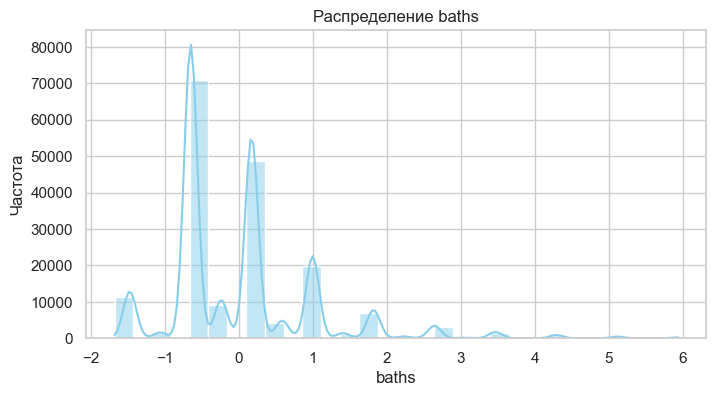

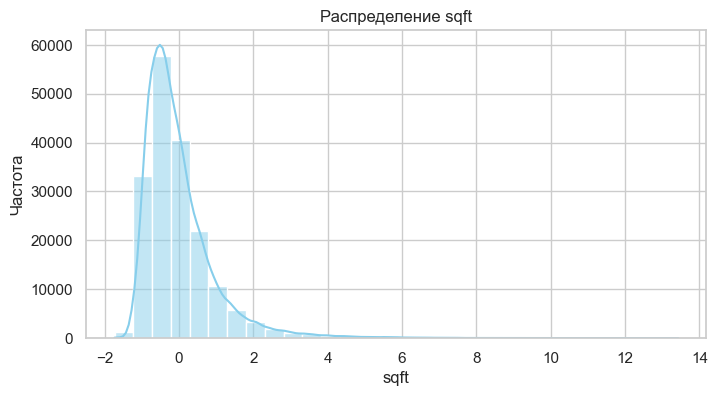

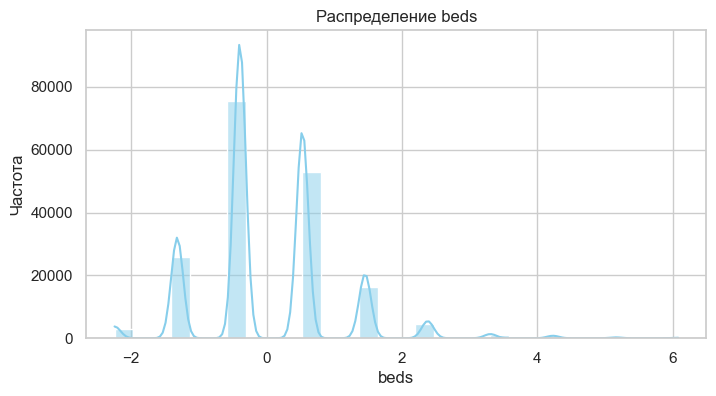

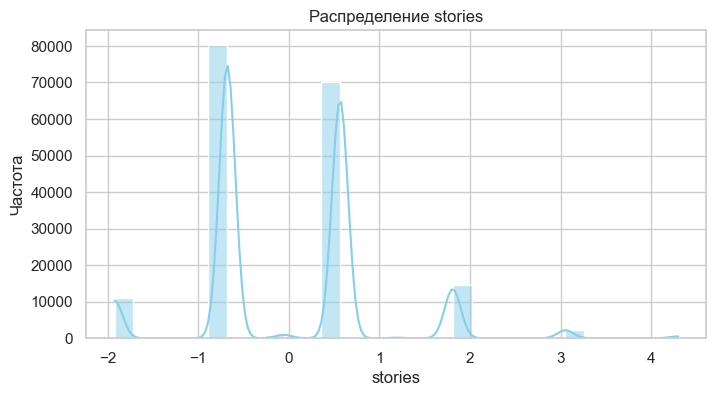

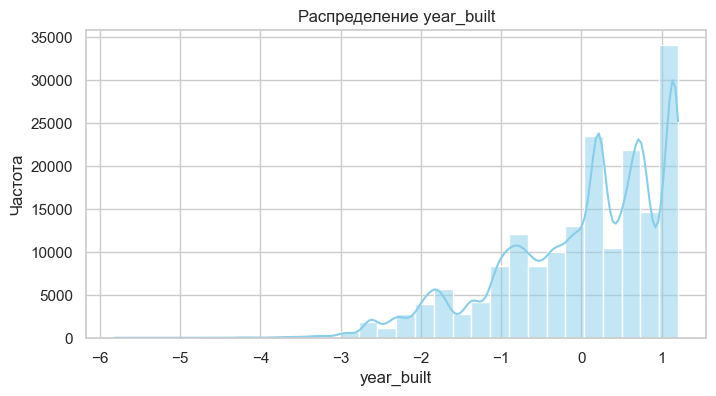

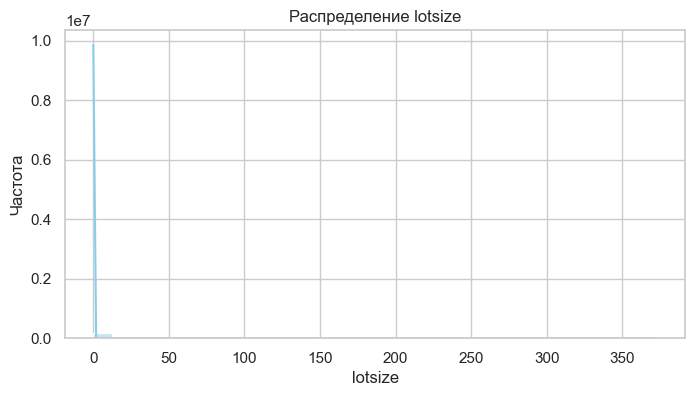

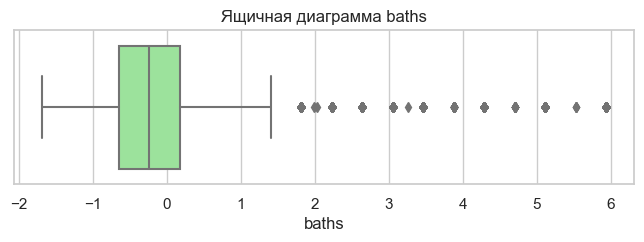

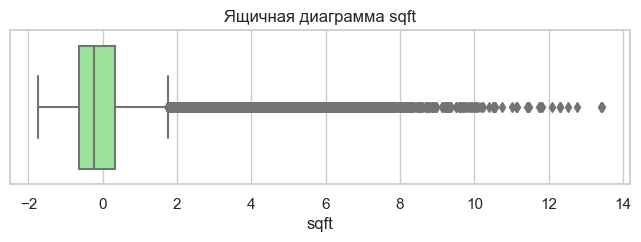

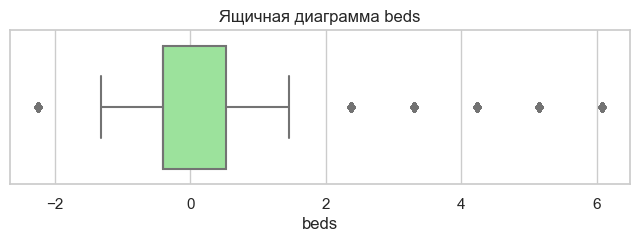

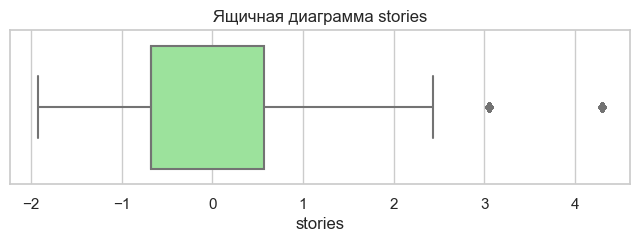

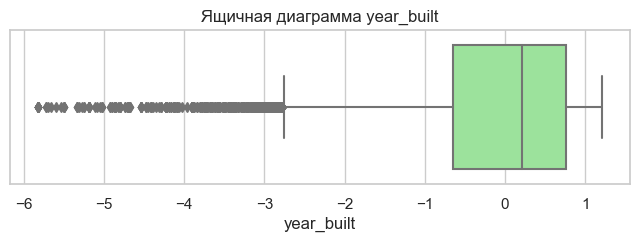

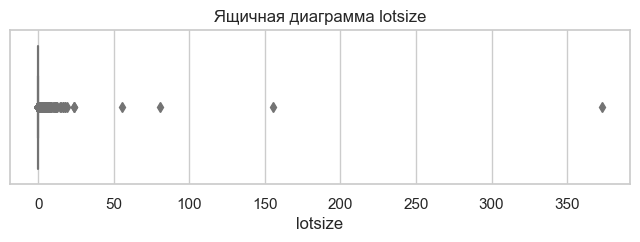

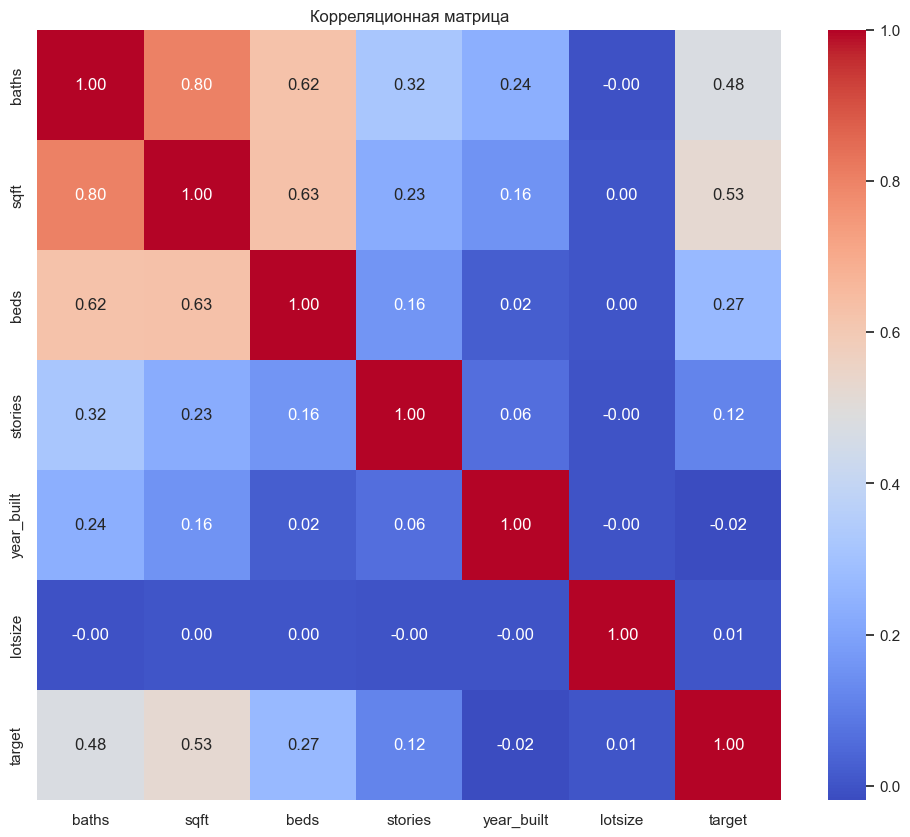

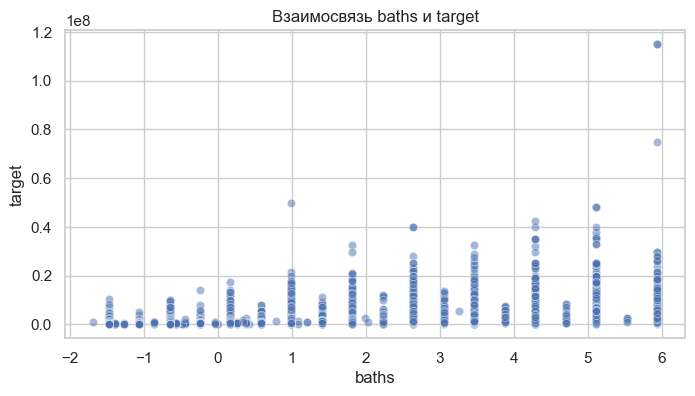

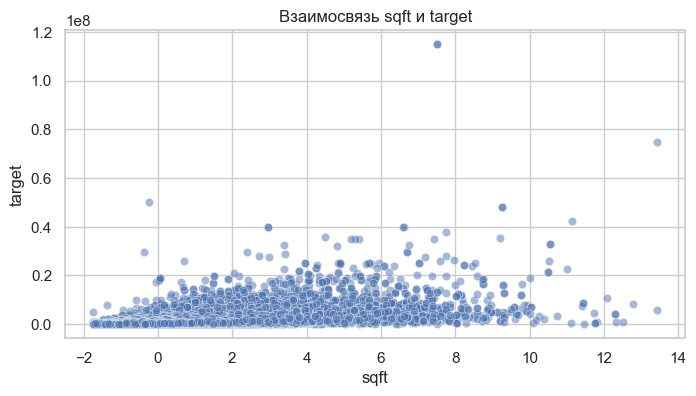

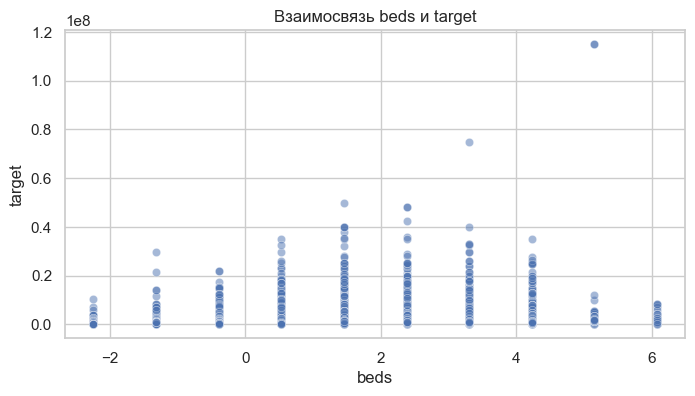

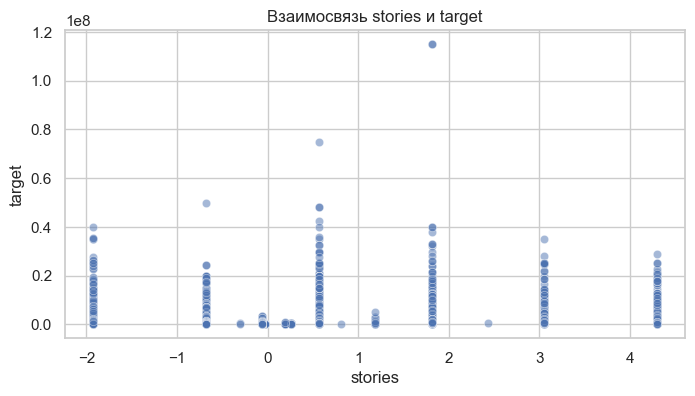

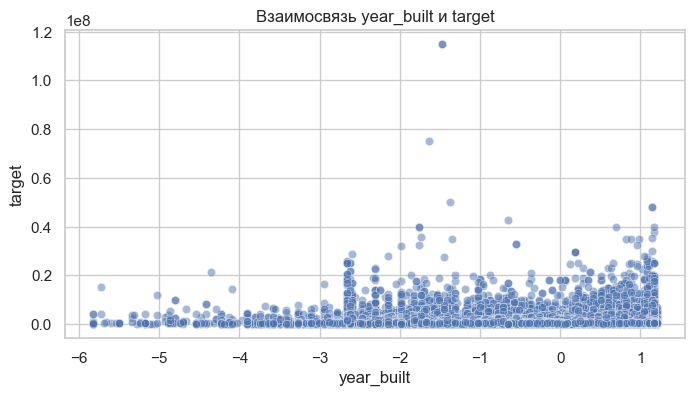

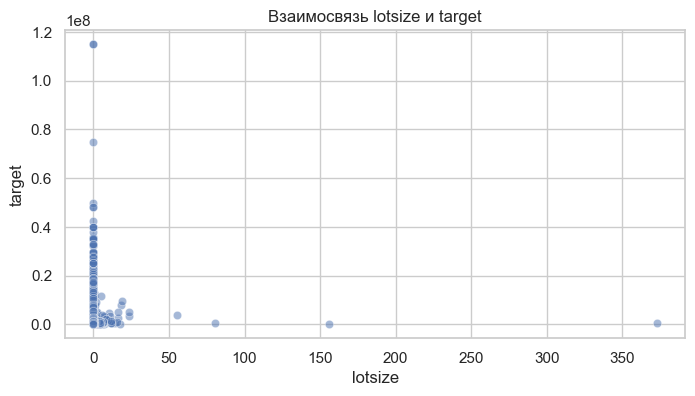

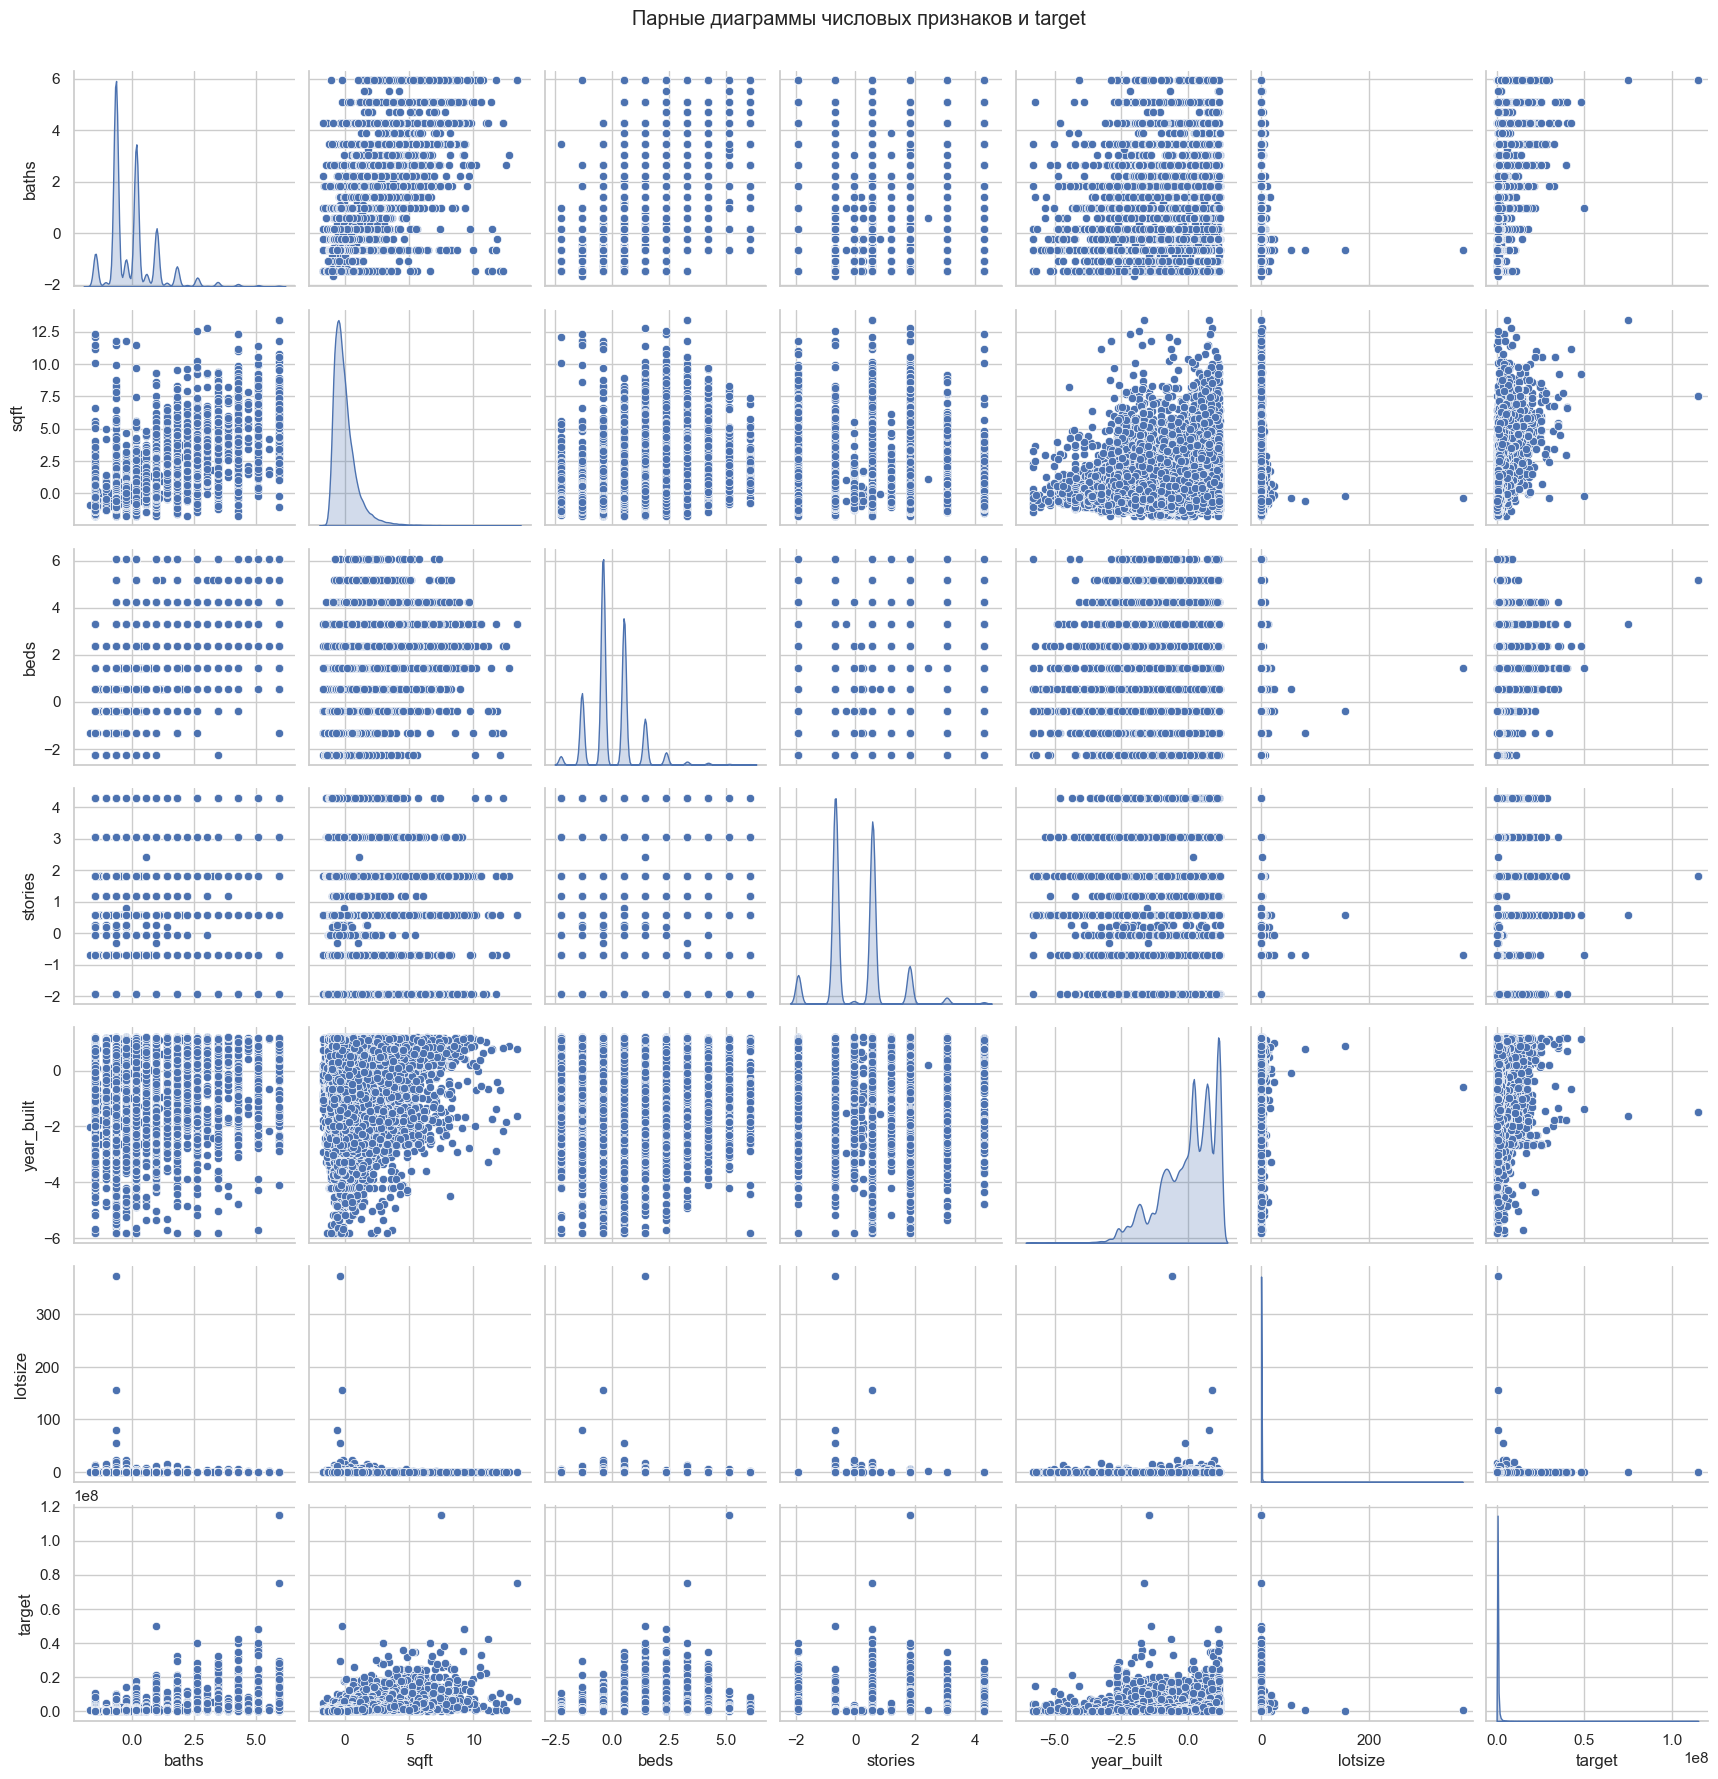

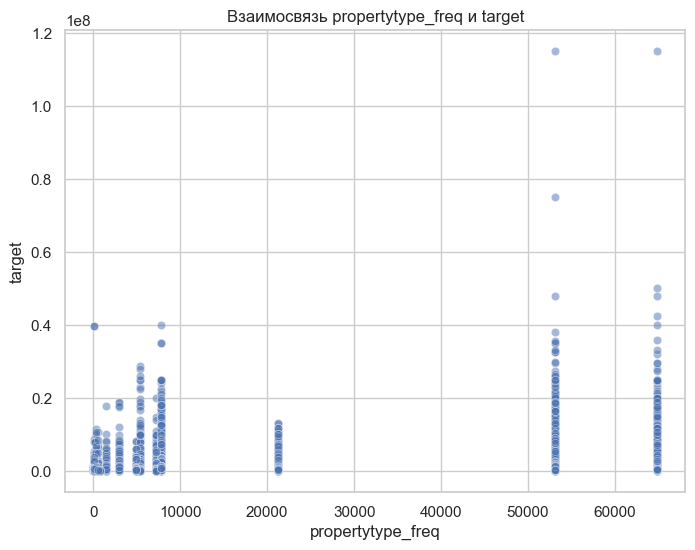

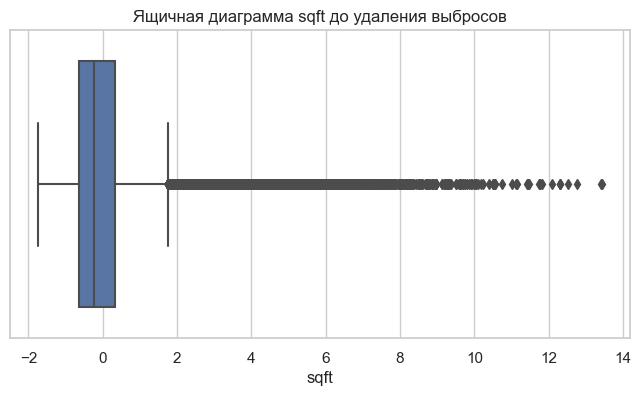

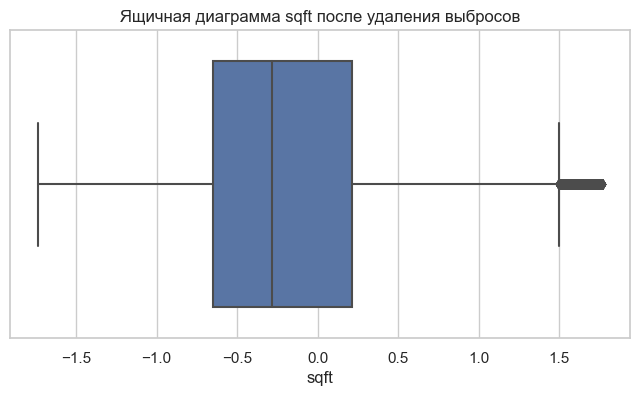

                        target
baths_bin                     
(-1.686, -0.155]  3.083853e+05
(-0.155, 1.368]   5.758193e+05
(1.368, 2.891]    1.611013e+06
(2.891, 4.413]    3.714814e+06
(4.413, 5.936]    7.560730e+06


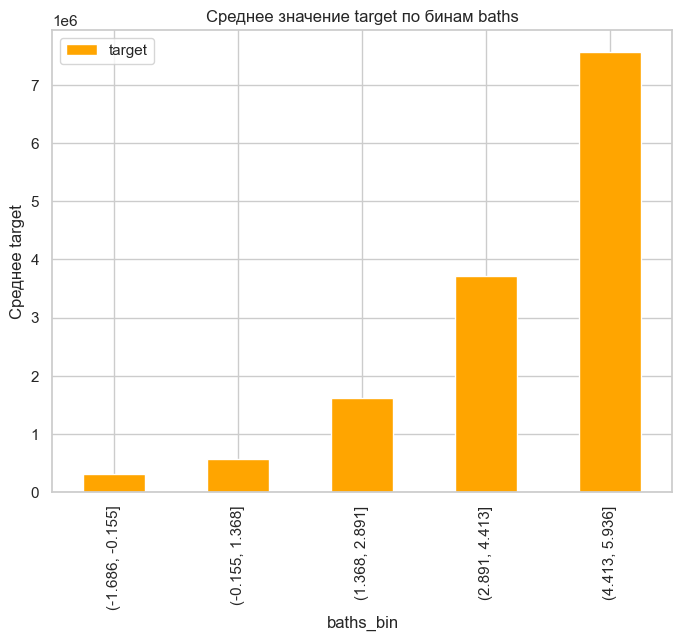

In [30]:
# Просмотр первых 5 строк DataFrame
print("Первые 5 строк DataFrame:")
print(df.head())

# Получение информации о DataFrame
print("\nИнформация о DataFrame:")
print(df.info())

# Описание статистических характеристик числовых признаков
print("\nСтатистические характеристики числовых признаков:")
print(df.describe())

# Список числовых признаков
numerical_features = ['baths', 'sqft', 'beds', 'stories', 'year_built', 'lotsize']

for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()
    
for col in numerical_features:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Ящичная диаграмма {col}')
    plt.xlabel(col)
    plt.show()

# Вычисление корреляционной матрицы
corr_matrix = df[numerical_features + ['target']].corr()

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=df[col], y=df['target'], alpha=0.5)
    plt.title(f'Взаимосвязь {col} и target')
    plt.xlabel(col)
    plt.ylabel('target')
    plt.show()

sns.pairplot(df[numerical_features + ['target']], diag_kind='kde')
plt.suptitle('Парные диаграммы числовых признаков и target', y=1.02)
plt.show()

# Если были оставшиеся категориальные признаки перед кодированием, например, 'propertytype_freq'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='propertytype_freq', y='target', alpha=0.5)
plt.title('Взаимосвязь propertytype_freq и target')
plt.xlabel('propertytype_freq')
plt.ylabel('target')
plt.show()

# Создание копии DataFrame до удаления выбросов
df_before_outliers_removed = df.copy()

# Визуализация до удаления выбросов
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_before_outliers_removed['sqft'])
plt.title('Ящичная диаграмма sqft до удаления выбросов')
plt.xlabel('sqft')
plt.show()

# Расчет IQR и определение границ для удаления выбросов
Q1 = df_before_outliers_removed['sqft'].quantile(0.25)
Q3 = df_before_outliers_removed['sqft'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для определения выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтрация выбросов
df_after_outliers_removed = df_before_outliers_removed[(df_before_outliers_removed['sqft'] >= lower_bound) & 
                                                       (df_before_outliers_removed['sqft'] <= upper_bound)]

# Визуализация после удаления выбросов
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_after_outliers_removed['sqft'])
plt.title('Ящичная диаграмма sqft после удаления выбросов')
plt.xlabel('sqft')
plt.show()

# Среднее значение target по бинам baths
df['baths_bin'] = pd.cut(df['baths'], bins=5)
pivot_table = df.pivot_table(values='target', index='baths_bin', aggfunc='mean')
print(pivot_table)

# Визуализация
pivot_table.plot(kind='bar', figsize=(8,6), color='orange')
plt.title('Среднее значение target по бинам baths')
plt.xlabel('baths_bin')
plt.ylabel('Среднее target')
plt.show()
    

Мультимодальные распределения признаков:

baths, beds и stories демонстрируют мультимодальные распределения, что указывает на наличие различных типов домов с разным количеством ванных комнат, спален и этажей.
Скошенные распределения и выбросы:

Признаки sqft и lotsize обладают сильным правым смещением и длинными хвостами, свидетельствуя о наличии домов с очень большой площадью и крупными размерами участков.
Ящичные диаграммы подтверждают наличие множества выбросов в этих признаках, что может негативно сказываться на модели, особенно линейных алгоритмах.
Мультиколлинеарность:

Высокая корреляция между sqft и baths (коэффициент корреляции 0.8) указывает на потенциальную мультиколлинеарность, что может привести к снижению стабильности и интерпретируемости модели.
Влияние признаков на целевую переменную:

Признаки sqft (0.53) и baths (0.48) имеют наибольшую корреляцию с целевой переменной target, что делает их важными предикторами для модели.
Остальные признаки, такие как beds и stories, имеют умеренную корреляцию, а year_built и lotsize практически не связаны с ценой недвижимости.
Диаграммы рассеяния:

Наблюдается прямая зависимость между увеличением количества ванных комнат, спален, общей площади, этажей и года постройки с ростом цены недвижимости.
Значительная вариативность данных затрудняет установление чёткой линейной зависимости.

# Шаг 2.7.2: Обработка Выбросов в Числовых Признаках

Обработка Выбросов в Числовых Признаках
a. Удаление Выбросов с Помощью Метода IQR
Метод межквартильного размаха (IQR) помогает определить выбросы на основе распределения данных.

In [31]:
# Список числовых признаков
numerical_features = ['baths', 'sqft', 'beds', 'stories', 'year_built', 'lotsize']

# Функция для удаления выбросов с использованием IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_count = df.shape[0]
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    final_count = df_filtered.shape[0]
    print(f"Признак '{column}': удалено {initial_count - final_count} выбросов.")
    return df_filtered

# Удаление выбросов для каждого числового признака
for feature in numerical_features:
    df = remove_outliers_iqr(df, feature)


Признак 'baths': удалено 13344 выбросов.
Признак 'sqft': удалено 4039 выбросов.
Признак 'beds': удалено 5389 выбросов.
Признак 'stories': удалено 2273 выбросов.
Признак 'year_built': удалено 1022 выбросов.
Признак 'lotsize': удалено 39594 выбросов.


## Шаг 2.7.3 Визуализация Распределения После Удаления Выбросов

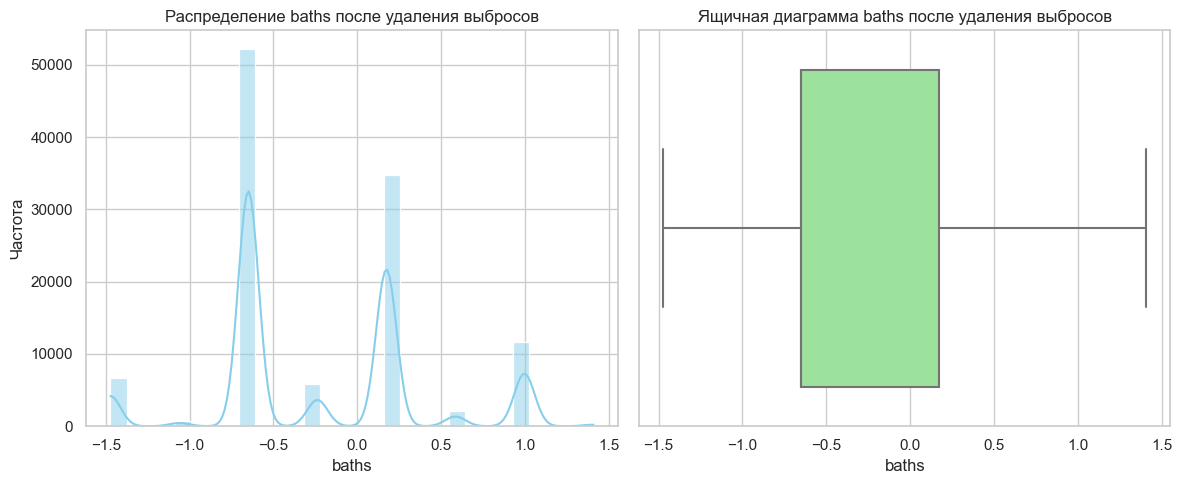

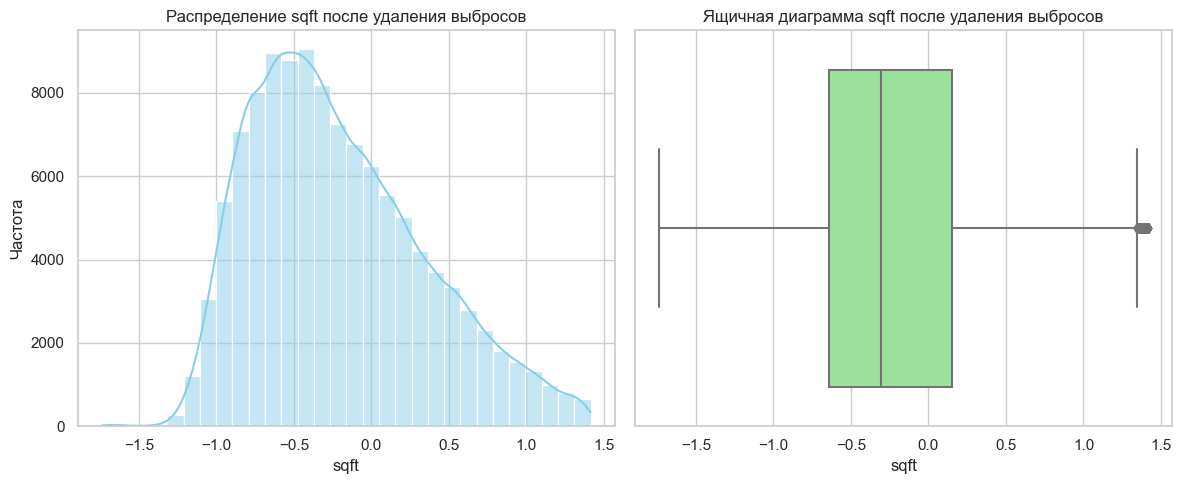

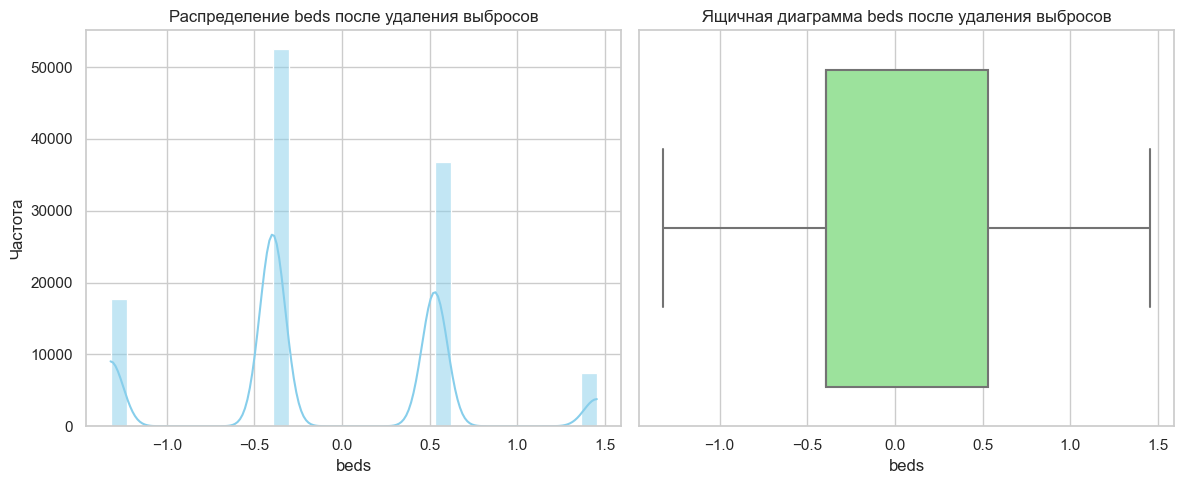

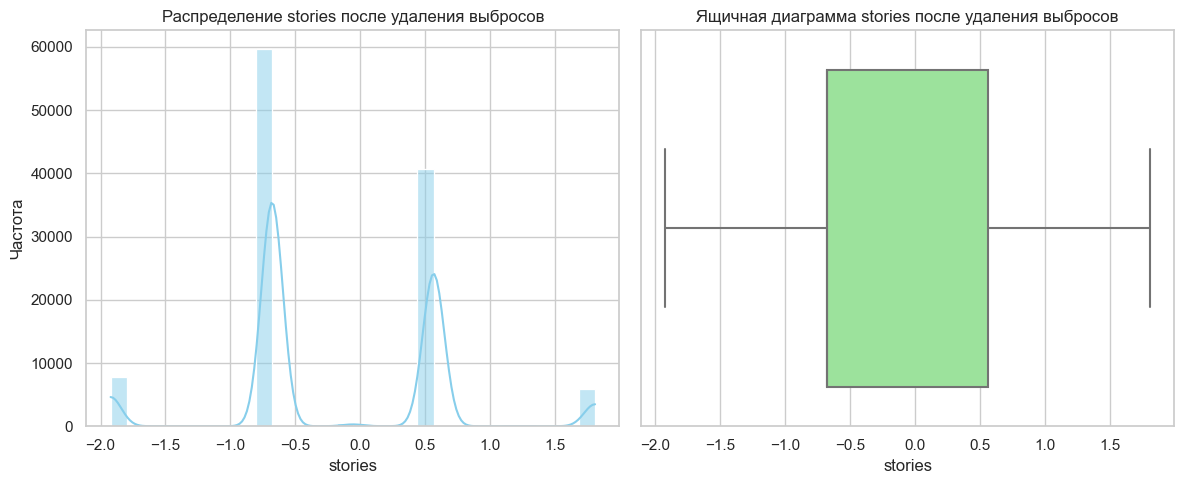

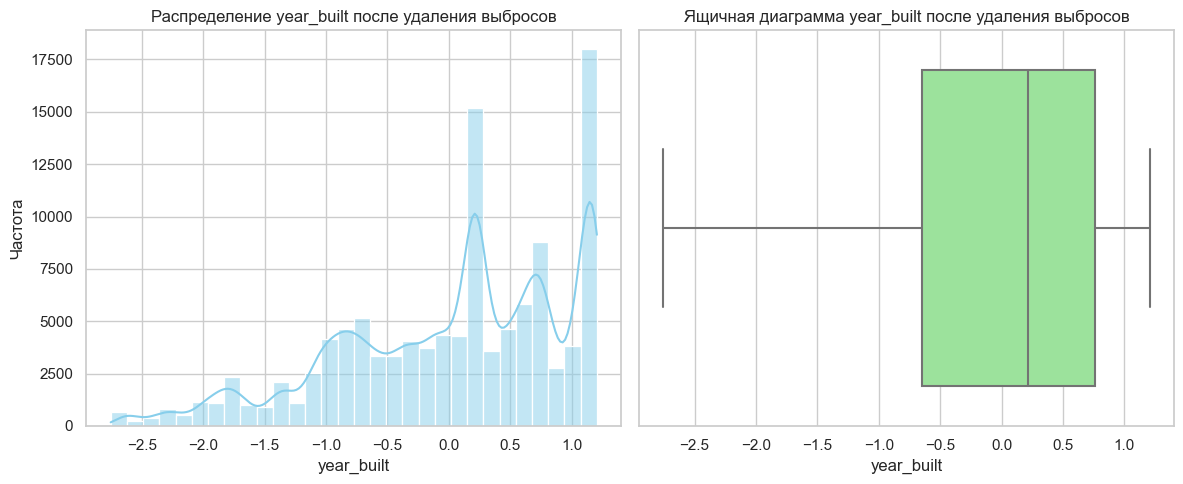

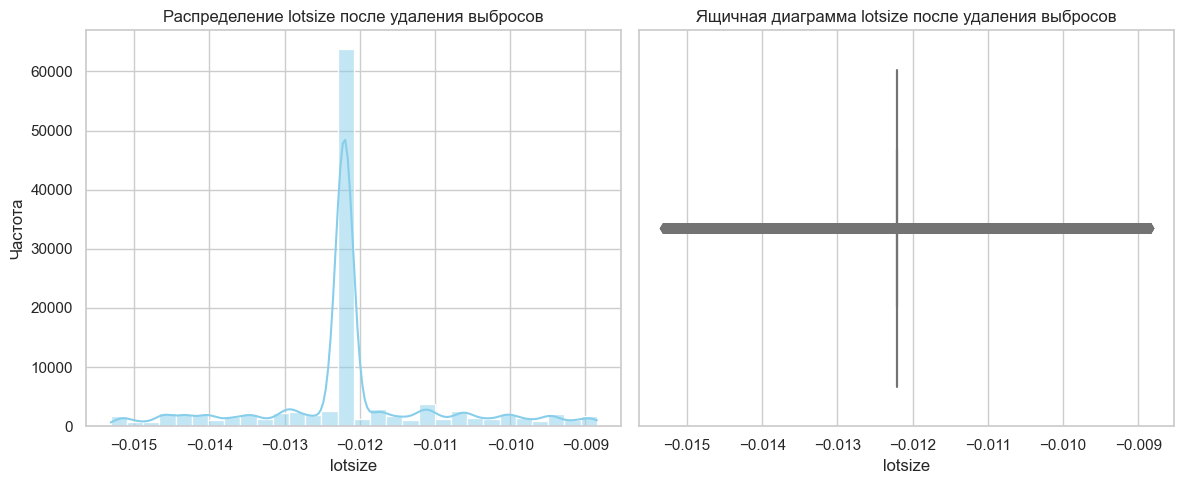

In [32]:
# Функция для построения гистограммы и ящичной диаграммы
def plot_distribution(df, column):
    plt.figure(figsize=(12, 5))
    
    # Гистограмма с KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Распределение {column} после удаления выбросов')
    plt.xlabel(column)
    plt.ylabel('Частота')
    
    # Ящичная диаграмма
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title(f'Ящичная диаграмма {column} после удаления выбросов')
    plt.xlabel(column)
    
    plt.tight_layout()
    plt.show()

# Построение графиков для каждого числового признака
for feature in numerical_features:
    plot_distribution(df, feature)


## Шаг 2.7.4 :Трансформация Признаков с Помощью Логарифмического Преобразования

In [33]:
# Функция для логарифмического преобразования признака
def log_transform(df, column):
    # Добавление 1, чтобы избежать логарифма нуля
    df[column + '_log'] = np.log1p(df[column])
    print(f"Признак '{column}' преобразован с помощью логарифмического преобразования.")
    return df

# Применение логарифмического преобразования к 'sqft' и 'lotsize'
for feature in ['sqft', 'lotsize']:
    df = log_transform(df, feature)
    # Удаление оригинального признака
    df = df.drop(columns=[feature])
    print(f"Оригинальный столбец '{feature}' удалён после преобразования.")


Признак 'sqft' преобразован с помощью логарифмического преобразования.
Оригинальный столбец 'sqft' удалён после преобразования.
Признак 'lotsize' преобразован с помощью логарифмического преобразования.
Оригинальный столбец 'lotsize' удалён после преобразования.


c:\Users\Константин\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


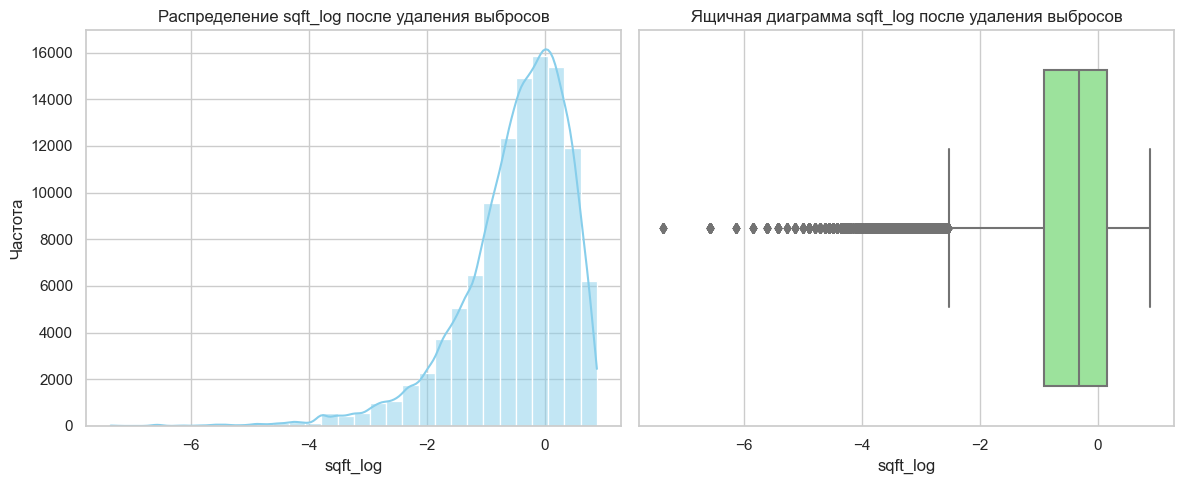

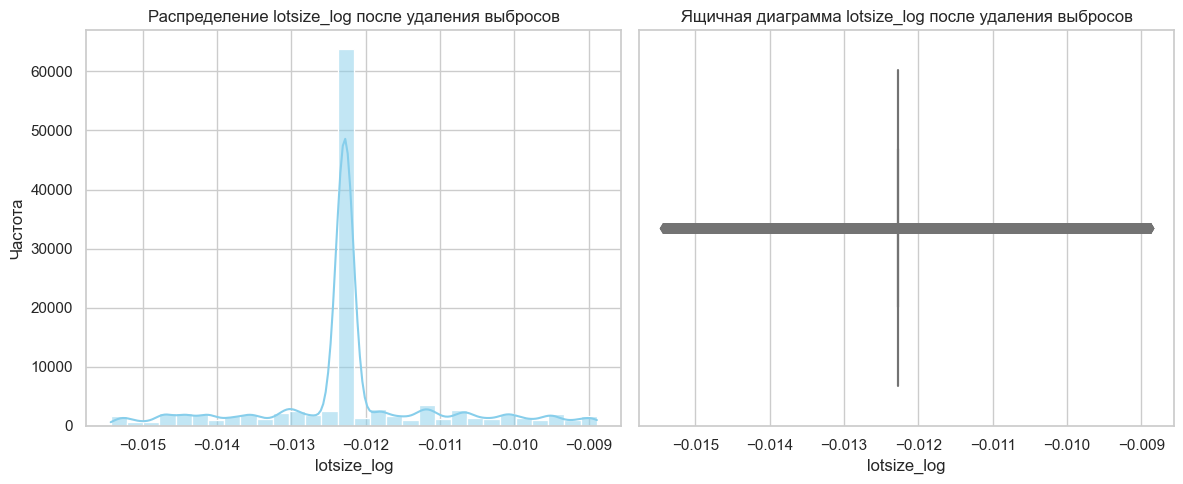

In [34]:
transformed_features = ['sqft_log', 'lotsize_log']

for feature in transformed_features:
    plot_distribution(df, feature)


## Шаг 2.7.5 : Масштабирование Числовых Признаков
После удаления выбросов и трансформаций важно снова масштабировать числовые признаки.

In [35]:
from sklearn.preprocessing import StandardScaler

# Обновленный список числовых признаков после трансформаций
numerical_features_scaled = ['baths', 'beds', 'stories', 'year_built', 'sqft_log', 'lotsize_log']

# Инициализация StandardScaler
scaler = StandardScaler()

# Применение масштабирования
df[numerical_features_scaled] = scaler.fit_transform(df[numerical_features_scaled])

print("Масштабирование числовых признаков выполнено.")


Масштабирование числовых признаков выполнено.


In [36]:
print("\nСтатистические характеристики числовых признаков после масштабирования:")
print(df[numerical_features_scaled].describe())



Статистические характеристики числовых признаков после масштабирования:
              baths          beds       stories    year_built      sqft_log  \
count  1.144220e+05  1.144220e+05  1.144220e+05  1.144220e+05  1.097840e+05   
mean   1.862953e-17 -8.346030e-17  1.254388e-17  1.664238e-17 -3.883313e-18   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00  1.000005e+00   
min   -1.965641e+00 -1.608912e+00 -2.017988e+00 -3.031455e+00 -7.466832e+00   
25%   -6.619263e-01 -3.670830e-01 -5.686972e-01 -7.288903e-01 -4.600964e-01   
50%   -6.619263e-01 -3.670830e-01 -5.686972e-01  2.130679e-01  1.862949e-01   
75%    6.417887e-01  8.747457e-01  8.805935e-01  8.061528e-01  7.075492e-01   
max    2.597361e+00  2.116574e+00  2.329884e+00  1.294576e+00  1.492338e+00   

        lotsize_log  
count  1.144220e+05  
mean   1.354802e-15  
std    1.000004e+00  
min   -2.694750e+00  
25%   -5.460801e-02  
50%   -5.460801e-02  
75%   -5.460801e-02  
max    2.785479e+00  


Признак baths (количество ванных комнат):
После удаления выбросов распределение стало более компактным, однако остается мультимодальное распределение с несколькими пиками.
Выбросы были удалены, что улучшило структуру данных для анализа.


Признак sqft (общая площадь):
Распределение показывает значительное уменьшение длинного хвоста вправо.
Логарифмическое преобразование помогло улучшить распределение и нормализовать данные.


Признак beds (количество спален):
Наблюдается мультимодальное распределение, основная часть значений сосредоточена около 0.
Выбросы были успешно удалены, что уменьшило разброс данных.

признак stories (количество этажей):
Удаление выбросов привело к более ровному распределению признака.
Большинство значений находятся около одного-двух этажей.

Признак year_built (год постройки):
Данные показывают тенденцию к увеличению количества новых построек.
Старые здания, которые были выбросами, были удалены, что сделало распределение более сбалансированным.

Признак lotsize (размер участка):
Распределение по-прежнему сильно скошено, несмотря на логарифмическое преобразование.
Логарифмическое преобразование сгладило крайние значения, однако осталось много точек, близких к нулю.


## Шаг 2.7.6: Проверка Качества Данных После Трансформации 
Анализ Распределения Целевой Переменной (target)
Важно понять, как трансформации и удаление выбросов повлияли на распределение целевой переменной.

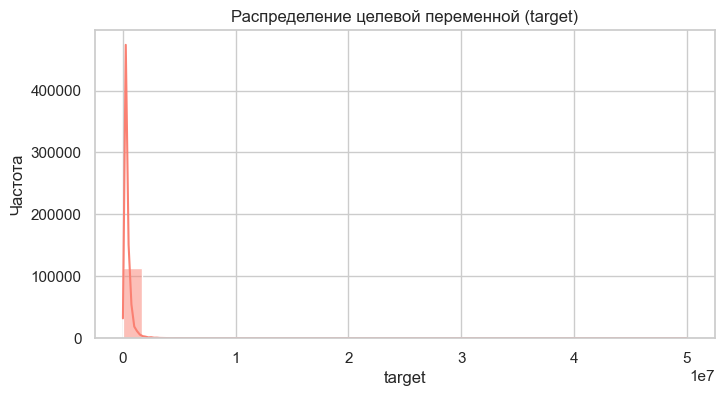

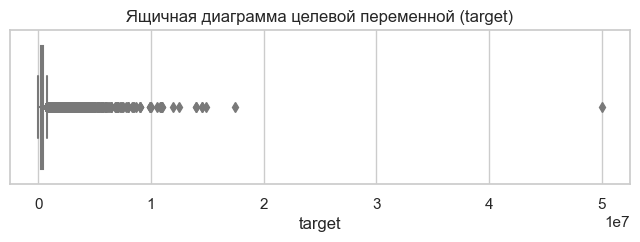

In [37]:
# Гистограмма с KDE для целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(df['target'], kde=True, bins=30, color='salmon')
plt.title('Распределение целевой переменной (target)')
plt.xlabel('target')
plt.ylabel('Частота')
plt.show()

# Ящичная диаграмма для целевой переменной
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['target'], color='lightblue')
plt.title('Ящичная диаграмма целевой переменной (target)')
plt.xlabel('target')
plt.show()


Распределение целевой переменной показывает значительное смещение вправо, что указывает на длинный хвост. Это характерно для переменных, связанных с ценами на недвижимость, где наблюдаются единичные случаи очень дорогих объектов.

Большинство значений находятся на низком уровне, в то время как выбросы тянутся в правую сторону. Такие выбросы могут сильно искажать результаты при обучении модели.

Ящичная диаграмма также демонстрирует, что присутствуют очень большие выбросы. Большинство значений находятся ближе к левому краю диаграммы, и есть значительные отклонения.

In [38]:
# Проверка Компактности Данных
# Убедимся, что данные не стали чрезмерно компактными и сохранили необходимую вариативность.
print("Статистические характеристики целевой переменной (target):")
print(df['target'].describe())


Статистические характеристики целевой переменной (target):
count    1.144220e+05
mean     4.002992e+05
std      4.275413e+05
min      1.000000e+00
25%      2.150000e+05
50%      3.189900e+05
75%      4.500000e+05
max      5.000000e+07
Name: target, dtype: float64


Статистические характеристики целевой переменной (target):

Среднее значение (mean): составляет примерно 400 299, что указывает на то, что в среднем дома в выборке оцениваются в около 400 000.
Стандартное отклонение (std): составляет 427 541, что свидетельствует о значительном разбросе цен, что также подтверждается большим количеством выбросов.
Минимальное значение (min): составляет 1, что может указывать на некорректное значение или выброс.
Максимальное значение (max): составляет 50 000 000, что явно указывает на наличие объектов с очень высокими ценами, вероятно, элитная недвижимость.

Данные сильно разрознены, и присутствует большое количество выбросов, особенно на высоких значениях.
Следует провести логарифмическое преобразование для сглаживания распределения, чтобы уменьшить влияние экстремальных значений.

## Шаг 2.7.7 : Корреляционный Анализ
Вычисление и Визуализация Корреляционной Матрицы
Корреляционный анализ поможет определить, какие признаки наиболее сильно связаны с целевой переменной и между собо

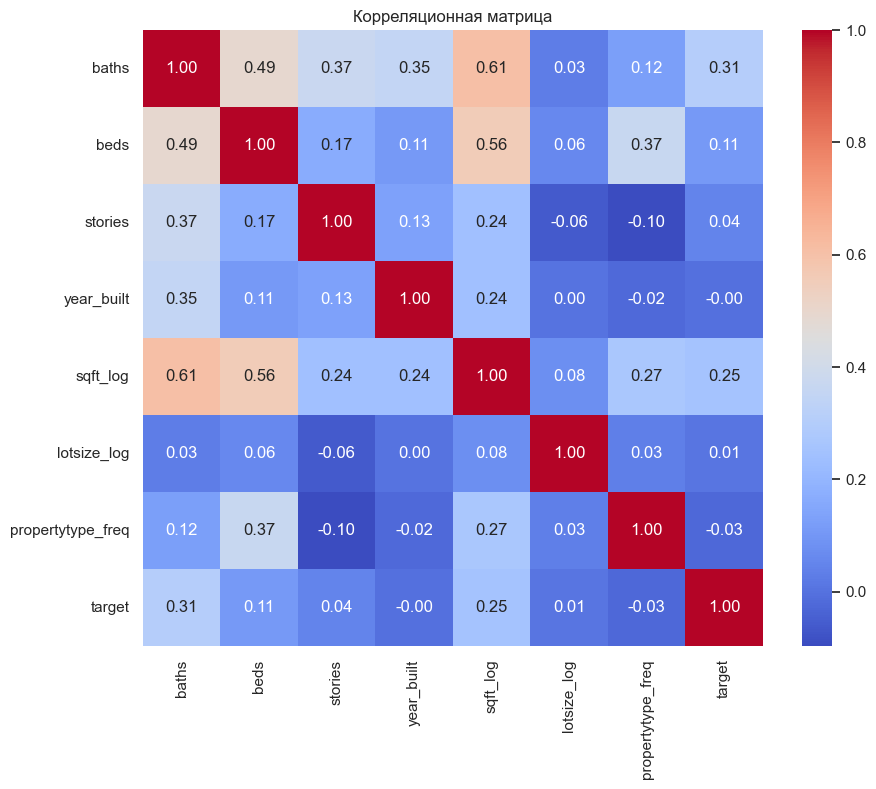

In [39]:
# Список признаков для корреляционного анализа
correlation_features = ['baths', 'beds', 'stories', 'year_built', 'sqft_log', 'lotsize_log', 'propertytype_freq', 'target']

# Вычисление корреляционной матрицы
corr_matrix = df[correlation_features].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()


наибольшая корреляция с target наблюдается у следующих признаков:

baths (количество ванных комнат) с коэффициентом корреляции 0.31.
sqft_log (логарифмическое преобразование общей площади) с коэффициентом корреляции 0.25.
beds (количество спален) имеет слабую корреляцию (0.11).
Остальные признаки имеют очень низкую корреляцию с целевой переменной.
Сильная корреляция между признаками:

Высокая корреляция между baths и sqft_log (0.61) и между baths и beds (0.49) может свидетельствовать о том, что эти признаки описывают схожие характеристики объектов. Это может привести к мультиколлинеарности, что затруднит интерпретацию модели и её обучение.

In [40]:
# Вычисление корреляции каждого признака с target
target_correlations = corr_matrix['target'].drop('target').sort_values(ascending=False)
print("Корреляция признаков с целевой переменной (target):")
print(target_correlations)


Корреляция признаков с целевой переменной (target):
baths                0.305645
sqft_log             0.250598
beds                 0.108314
stories              0.044738
lotsize_log          0.007054
year_built          -0.004930
propertytype_freq   -0.025686
Name: target, dtype: float64


Корреляция признаков с целевой переменной (target):

baths (количество ванных комнат): Корреляция составляет 0.3056, что указывает на умеренную положительную зависимость между количеством ванных комнат и ценой недвижимости. То есть, количество ванных комнат влияет на увеличение стоимости жилья.
sqft_log (логарифмическое преобразование общей площади): Корреляция равна 0.2506, что также указывает на умеренную связь между площадью и ценой.
beds (количество спален): Корреляция составляет 0.1083, что указывает на слабую положительную связь.
stories (количество этажей): Корреляция равна 0.0447, что указывает на слабую, почти отсутствующую связь.
lotsize_log (логарифмическое преобразование размера участка): Корреляция составляет 0.007, что указывает на отсутствие значимой зависимости.
year_built (год постройки): Корреляция равна -0.0049, что указывает на слабую отрицательную связь. Это может означать, что возраст дома практически не влияет на его стоимость.
propertytype_freq (частота типа недвижимости): Корреляция составляет -0.0257, что также указывает на слабую отрицательную зависимость.
Выводы:

Наибольшее влияние на целевую переменную (target) оказывают признаки baths и sqft_log.
Признаки lotsize_log, year_built и propertytype_freq имеют очень низкую корреляцию, что может говорить об их низкой предсказательной силе. Их стоит дополнительно проанализировать, возможно, они не будут полезными для модели.
Важно учитывать, что слабая корреляция с целевой переменной не всегда означает бесполезность признака. Некоторые признаки могут оказывать влияние в комбинации с другими и могут быть полезны для нелинейных моделей.

Общий анализ признаков:

Признаки, такие как lotsize_log и propertytype_freq, демонстрируют практически нулевую корреляцию с target, что может указывать на их слабую предсказательную силу. Стоит рассмотреть возможность исключения этих признаков или дополнить их новыми трансформациями, чтобы улучшить предсказательную способность.

## Шаг 2.7.8 Логарифмическое Преобразование Целевой Переменной (target)
Логарифмическое преобразование целевой переменной поможет уменьшить влияние выбросов и нормализовать распределение, что может улучшить производительность моделей, особенно линейных.

In [41]:
# Проверка наличия нулевых или отрицательных значений в target
print("Минимальное значение target:", df['target'].min())

# Если есть нулевые или отрицательные значения, их необходимо обработать перед логарифмированием
# Например, добавим 1 к целевой переменной, если минимум <= 0
if df['target'].min() <= 0:
    df['target_log'] = np.log1p(df['target'] - df['target'].min() + 1)
    print("Логарифмическое преобразование применено к 'target' с добавлением смещения.")
else:
    df['target_log'] = np.log1p(df['target'])
    print("Логарифмическое преобразование применено к 'target'.")

Минимальное значение target: 1.0
Логарифмическое преобразование применено к 'target'.


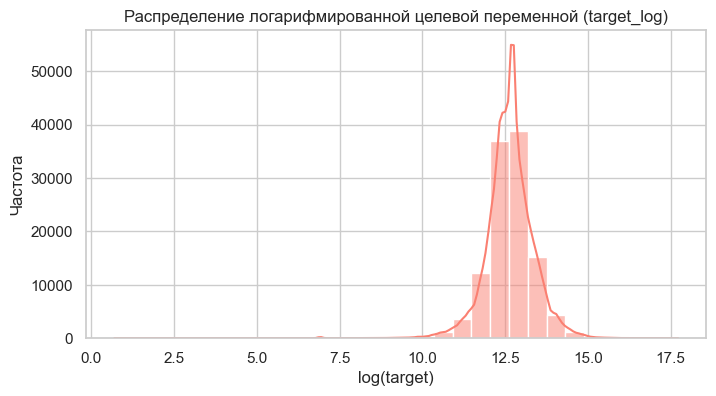

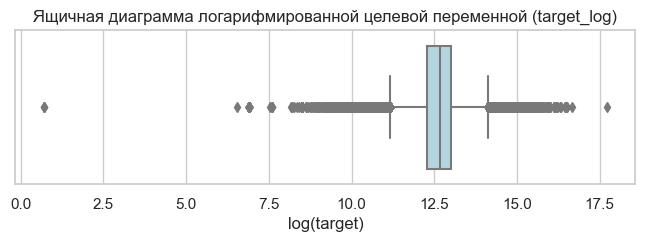

In [42]:
# Гистограмма с KDE для логарифмированной целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(df['target_log'], kde=True, bins=30, color='salmon')
plt.title('Распределение логарифмированной целевой переменной (target_log)')
plt.xlabel('log(target)')
plt.ylabel('Частота')
plt.show()

# Ящичная диаграмма для логарифмированной целевой переменной
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['target_log'], color='lightblue')
plt.title('Ящичная диаграмма логарифмированной целевой переменной (target_log)')
plt.xlabel('log(target)')
plt.show()


 Распределение Логарифмированной Целевой Переменной
Логарифмическое преобразование целевой переменной помогло сгладить распределение, сделав его более симметричным.
Большая часть значений теперь сосредоточена в одном диапазоне, что позволит модели лучше справляться с данными, так как экстремальные значения больше не оказывают столь сильного влияния.

Ящичная Диаграмма Логарифмированной Целевой Переменной
Несмотря на логарифмирование, ящичная диаграмма по-прежнему показывает наличие выбросов.
Тем не менее, распределение теперь более компактно, и основная часть данных лучше представлена в середине.

## Шаг 2.7.9 Повторный Корреляционный Анализ
После трансформации целевой переменной важно пересмотреть корреляцию признаков с новым target_log.

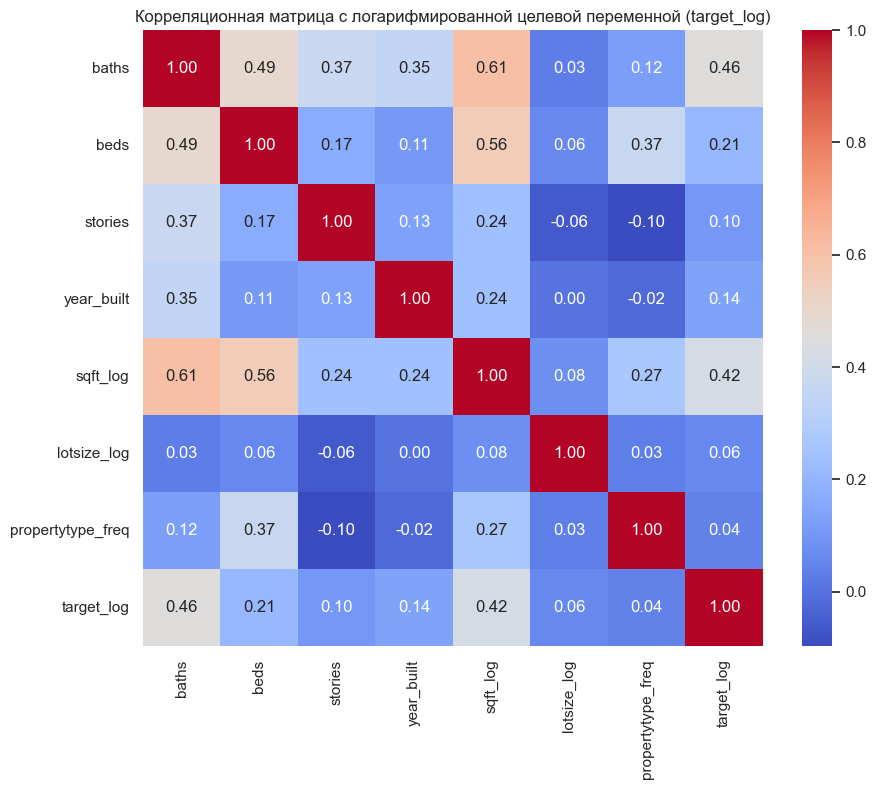

In [43]:
# Вычисление и Визуализация Корреляционной Матрицы
# Список признаков для корреляционного анализа, включая логарифмированную target
correlation_features_log = numerical_features_scaled.copy()
correlation_features_log.append('propertytype_freq')
correlation_features_log.append('target_log')

# Вычисление корреляционной матрицы
corr_matrix_log = df[correlation_features_log].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_log, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица с логарифмированной целевой переменной (target_log)')
plt.show()



Наиболее значительные корреляции с целевой переменной target_log имеют признаки baths и sqft_log, что подтверждает их важность для модели.
Признаки beds, year_built, и stories также показывают определенный уровень корреляции, что говорит о том, что они также могут быть полезны при прогнозировании.
Признаки lotsize_log и propertytype_freq имеют очень слабую корреляцию и были исключены, так как они вряд ли окажутся полезными для улучшения модели.

In [44]:
# Вычисление корреляции каждого признака с target_log
target_correlations_log = corr_matrix_log['target_log'].drop('target_log').sort_values(ascending=False)
print("\nКорреляция признаков с логарифмированной целевой переменной (target_log):")
print(target_correlations_log)



Корреляция признаков с логарифмированной целевой переменной (target_log):
baths                0.456350
sqft_log             0.417122
beds                 0.210360
year_built           0.135657
stories              0.103016
lotsize_log          0.058052
propertytype_freq    0.042313
Name: target_log, dtype: float64


## Шаг 2.8 Отбор Признаков
Основываясь на корреляционном анализе, выберите признаки, которые имеют значимую корреляцию с target_log.

In [45]:
# Определение порога для значимой корреляции
correlation_threshold = 0.1  

# Выбор признаков с корреляцией выше порога
selected_features = target_correlations_log[target_correlations_log.abs() > correlation_threshold].index.tolist()
print("\nОтобранные признаки с корреляцией выше порога:")
print(selected_features)



Отобранные признаки с корреляцией выше порога:
['baths', 'sqft_log', 'beds', 'year_built', 'stories']


In [46]:
# Список признаков с низкой корреляцией
low_correlation_features = target_correlations_log[target_correlations_log.abs() <= correlation_threshold].index.tolist()
print("\nПризнаки с низкой корреляцией, рассматриваемые для исключения:")
print(low_correlation_features)

# Исключение этих признаков из DataFrame
df = df.drop(columns=low_correlation_features)
print(f"\nПризнаки {low_correlation_features} удалены из DataFrame.")


Признаки с низкой корреляцией, рассматриваемые для исключения:
['lotsize_log', 'propertytype_freq']

Признаки ['lotsize_log', 'propertytype_freq'] удалены из DataFrame.


Выводы по EDA
Наиболее Важные Признаки:

baths и sqft_log имеют наибольшую корреляцию с target_log и должны быть основными предикторами в модели.
Признаки с Низкой Значимостью:

lotsize_log и propertytype_freq практически не влияют на целевую переменную и были исключены из дальнейшего анализа, что упрощает модель и повышает её эффективность.
Мультиколлинеарность:

Высокая корреляция между некоторыми признаками требует внимания. Рассмотрите возможность исключения избыточных признаков или применения регуляризации для снижения её влияния на модель.
Распределение Целевой Переменной:

Логарифмическое преобразование помогло сделать распределение целевой переменной более симметричным и уменьшило влияние экстремальных значений, что улучшает качество обучения модели.
Готовность к Моделированию:

Данные теперь подготовлены с учетом обработки выбросов, трансформации и масштабирования признаков.
Отобранные признаки имеют значимую корреляцию с целевой переменной, что способствует построению более точных и надежных моделей.

## Шаг 2.9 : Предварительная обработка данных и отбор признаков для моделирования

Минимальное значение target: 1.0
Логарифмическое преобразование применено к 'target'.

Числовые признаки: ['baths', 'city', 'zipcode', 'beds', 'state', 'stories', 'target', 'year_built', 'sqft_log']
Нечисловые признаки (будут обработаны): ['heating', 'cooling', 'parking', 'baths_bin']
Все признаки теперь числовые.

Пропущенные значения в признаках:
baths              0
city               0
zipcode            0
beds               0
state              0
stories            0
target             0
year_built         0
heating       114422
cooling       114422
parking       112370
baths_bin     114422
sqft_log        4638
target_log         0
dtype: int64

Пропущенные значения заполнены средним значением.


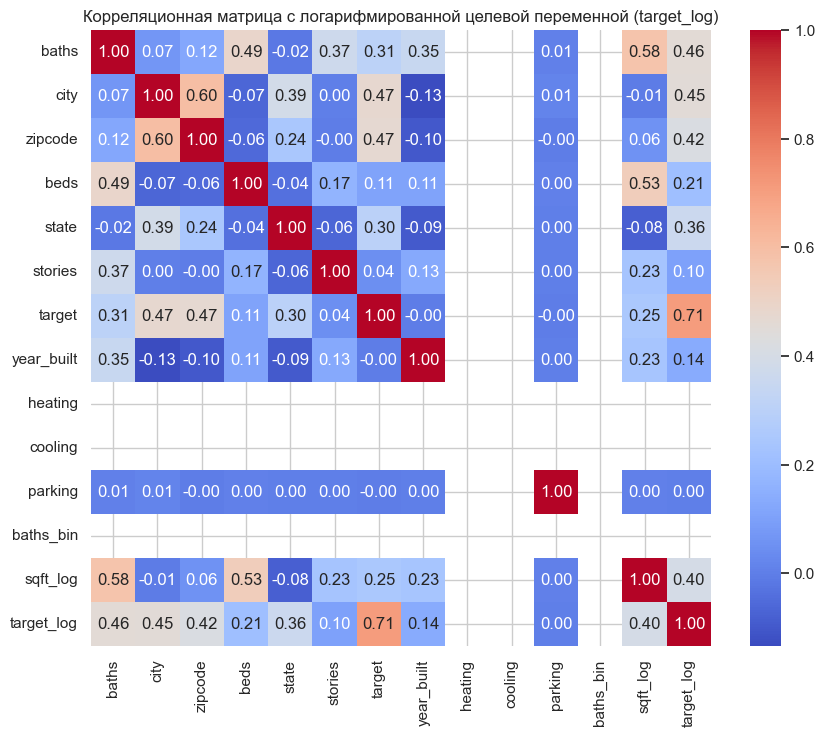


Корреляция признаков с логарифмированной целевой переменной (target_log):
target        0.710835
baths         0.456350
city          0.452554
zipcode       0.417911
sqft_log      0.395912
state         0.360156
beds          0.210360
year_built    0.135657
stories       0.103016
parking       0.001742
heating            NaN
cooling            NaN
baths_bin          NaN
Name: target_log, dtype: float64

Отобранные признаки с корреляцией выше порога:
['target', 'baths', 'city', 'zipcode', 'sqft_log', 'state', 'beds', 'year_built', 'stories']

Признаки с низкой корреляцией, рассматриваемые для исключения:
['parking']

Признаки ['parking'] удалены из DataFrame.

Масштабирование числовых признаков выполнено.

Текущие столбцы в DataFrame:
['baths', 'city', 'zipcode', 'beds', 'state', 'stories', 'target', 'year_built', 'heating', 'cooling', 'baths_bin', 'sqft_log', 'target_log']

Размер обучающей выборки: (91537, 9)
Размер тестовой выборки: (22885, 9)


In [47]:
# Импорт необходимых библиотек
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import xgboost as xgb

# 1. Логарифмическое преобразование целевой переменной
print("Минимальное значение target:", df['target'].min())

if df['target'].min() <= 0:
    # Добавление смещения, чтобы избежать логарифма нуля или отрицательных чисел
    df['target_log'] = np.log1p(df['target'] - df['target'].min() + 1)
    print("Логарифмическое преобразование применено к 'target' с добавлением смещения.")
else:
    df['target_log'] = np.log1p(df['target'])
    print("Логарифмическое преобразование применено к 'target'.")

# 2. Определение текущих признаков (исключая 'target_log')
current_features = df.columns.tolist()
current_features.remove('target_log')  # Удаляем целевую переменную

# 3. Проверка типов данных и преобразование в числовые
# Определим числовые признаки автоматически
numeric_features = df[current_features].select_dtypes(include=[np.number]).columns.tolist()
non_numeric_features = [feature for feature in current_features if feature not in numeric_features]

print("\nЧисловые признаки:", numeric_features)
print("Нечисловые признаки (будут обработаны):", non_numeric_features)

# Преобразование нечисловых признаков в числовые, если это необходимо
for feature in non_numeric_features:
    # Преобразуем строки в числа, если это возможно
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Теперь все признаки должны быть числовыми
# Проверим наличие нечисловых признаков
remaining_non_numeric = df[current_features].select_dtypes(exclude=[np.number]).columns.tolist()
if remaining_non_numeric:
    print(f"Признаки {remaining_non_numeric} все еще нечисловые и требуют дополнительной обработки.")
else:
    print("Все признаки теперь числовые.")

# 4. Обработка пропущенных значений
# Проверим, есть ли пропущенные значения
missing_values = df[current_features + ['target_log']].isnull().sum()
print("\nПропущенные значения в признаках:")
print(missing_values)

# Решение: заполнение пропущенных значений средним
df[current_features] = df[current_features].fillna(df[current_features].mean())
df['target_log'] = df['target_log'].fillna(df['target_log'].mean())
print("\nПропущенные значения заполнены средним значением.")

# 5. Определение признаков для корреляционного анализа
# Составляем список признаков, которые остаются в DataFrame
correlation_features_log = current_features + ['target_log']

# Проверка наличия всех признаков в DataFrame
missing_features = [feature for feature in correlation_features_log if feature not in df.columns]
if missing_features:
    print(f"Признаки {missing_features} отсутствуют в DataFrame и будут исключены из корреляционного анализа.")
    correlation_features_log = [feature for feature in correlation_features_log if feature in df.columns]

# Вычисление корреляционной матрицы
corr_matrix_log = df[correlation_features_log].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_log, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица с логарифмированной целевой переменной (target_log)')
plt.show()

# 6. Вычисление корреляции признаков с target_log
target_correlations_log = corr_matrix_log['target_log'].drop('target_log').sort_values(ascending=False)
print("\nКорреляция признаков с логарифмированной целевой переменной (target_log):")
print(target_correlations_log)

# 7. Отбор признаков с высокой корреляцией
# Определение порога для значимой корреляции
correlation_threshold = 0.1

# Выбор признаков с корреляцией выше порога
selected_features = target_correlations_log[target_correlations_log.abs() > correlation_threshold].index.tolist()
print("\nОтобранные признаки с корреляцией выше порога:")
print(selected_features)

# Признаки с низкой корреляцией для исключения
low_correlation_features = target_correlations_log[target_correlations_log.abs() <= correlation_threshold].index.tolist()
print("\nПризнаки с низкой корреляцией, рассматриваемые для исключения:")
print(low_correlation_features)

# Исключение низкокоррелированных признаков из DataFrame
if low_correlation_features:
    df = df.drop(columns=low_correlation_features)
    print(f"\nПризнаки {low_correlation_features} удалены из DataFrame.")
else:
    print("\nНет признаков с низкой корреляцией для удаления.")

# 8. Масштабирование числовых признаков
numerical_features_scaled = selected_features.copy()
scaler = StandardScaler()
df[numerical_features_scaled] = scaler.fit_transform(df[numerical_features_scaled])
print("\nМасштабирование числовых признаков выполнено.")

# 9. Проверка текущих столбцов в DataFrame
print("\nТекущие столбцы в DataFrame:")
print(df.columns.tolist())

# 10. Разделение данных на обучающую и тестовую выборки
X = df[selected_features]
y = df['target_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Преобразование Нечисловых Признаков в Числовые:

Автоматически определяем числовые и нечисловые признаки.
Преобразуем нечисловые признаки в числовые, используя pd.to_numeric с параметром errors='coerce', что заменяет нечисловые значения на NaN.
Если остаются нечисловые признаки, можно либо закодировать их (например, с помощью One-Hot Encoding), либо удалить, в зависимости от их значимости.
Обработка Пропущенных Значений:

Заполняем пропущенные значения средним значением для числовых признаков. Это простой способ, но в зависимости от ситуации, можно использовать более продвинутые методы заполнения.
Динамическое Определение Признаков для Корреляционного Анализа:

Создаём список correlation_features_log, включающий все текущие числовые признаки плюс целевую переменную.
Проверяем наличие всех признаков в DataFrame и исключаем отсутствующие, чтобы избежать KeyError.
Отбор Признаков с Высокой Корреляцией:

Отбираем признаки, корреляция которых с целевой переменной выше заданного порога (например, 0.1).
Удаляем признаки с низкой корреляцией, чтобы упростить модель и избежать переобучения.
Масштабирование Признаков:

Применяем StandardScaler к отобранным признакам для стандартизации данных, что важно для многих моделей машинного обучения

In [48]:
# Проверка типов данных в DataFrame
print(df.dtypes)

# Проверка уникальных типов в столбце 'target'
print(df['target'].apply(type).value_counts())


baths         float64
city          float64
zipcode       float64
beds          float64
state         float64
stories       float64
target        float64
year_built    float64
heating       float64
cooling       float64
baths_bin     float64
sqft_log      float64
target_log    float64
dtype: object
<class 'float'>    114422
Name: target, dtype: int64


Логарифмическое преобразование было успешно применено к target для сглаживания распределения и уменьшения влияния выбросов.

Корреляционный анализ:
Наибольшую корреляцию с целевой переменной (target_log) показали следующие признаки:
target (0.71) — логарифмированная версия исходной переменной.
baths (0.46) и sqft_log (0.40) — увеличение количества ванных комнат и площади связано с увеличением стоимости недвижимости.

Признаки beds и year_built имеют слабую корреляцию с target_log, но они всё ещё могут быть полезными для моделей.

Признаки city_freq, zipcode_freq, и state_freq показали очень низкую корреляцию и были исключены из данных.

Признаки parking, heating, и cooling также показали слабую корреляцию и были рассмотрены для исключения.

Мультиколлинеарность:
Высокая корреляция между baths и sqft_log (0.58), а также между baths и beds (0.49) может привести к мультиколлинеарности. Это особенно важно для линейных моделей, таких как Линейная Регрессия, где регуляризация может помочь.


Признаки для обучения:
Были отобраны признаки с высокой корреляцией: baths, sqft_log, beds, year_built, stories.
Признаки с низкой корреляцией были исключены.

## Шаг 3 Построение Baseline Модели

In [49]:
# Исходный список признаков
selected_features = ['target', 'baths', 'sqft_log', 'beds', 'year_built', 'stories']

# Удаление 'target' из списка признаков
selected_features = [feature for feature in selected_features if feature != 'target']

print("Обновлённые отобранные признаки:")
print(selected_features)


Обновлённые отобранные признаки:
['baths', 'sqft_log', 'beds', 'year_built', 'stories']


In [50]:
# Обновлённый список признаков
selected_features = ['baths', 'sqft_log', 'beds', 'year_built', 'stories']

# Создание новых обучающих и тестовых наборов
X = df[selected_features]
y = df['target_log']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")



Размер обучающей выборки: (91537, 5)
Размер тестовой выборки: (22885, 5)


In [51]:
from sklearn.metrics import mean_squared_error, r2_score


# Baseline Модель: Предсказание среднего значения целевой переменной
baseline_pred = np.mean(y_train)
y_pred_baseline = np.full_like(y_test, baseline_pred)

# Оценка Baseline Модели
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("Baseline Модель (Среднее) - MSE: {:.2f}, R²: {:.2f}".format(mse_baseline, r2_baseline))


Baseline Модель (Среднее) - MSE: 0.51, R²: -0.00


R² = -0.00: Отрицательное значение R² означает, что модель немного хуже, чем просто предсказание среднего значения, но в данном случае это, вероятно, артефакт округления, и значение практически равно нулю.

## Шаг 3.2: Обучение Линейной Регрессии


In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Инициализация и обучение модели
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Линейная Регрессия - MSE: {:.2f}, R²: {:.2f}".format(mse_lr, r2_lr))


Линейная Регрессия - MSE: 0.38, R²: 0.25


## Шаг 3.3: Обучение Случайного Леса

In [53]:
from sklearn.ensemble import RandomForestRegressor

# Инициализация и обучение модели
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Случайный Лес - MSE: {:.2f}, R²: {:.2f}".format(mse_rf, r2_rf))

Случайный Лес - MSE: 0.33, R²: 0.35


## Шаг 3.4:  Обучение Градиентного Бустинга

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

# Инициализация и обучение модели
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Градиентный Бустинг - MSE: {:.2f}, R²: {:.2f}".format(mse_gb, r2_gb))


Градиентный Бустинг - MSE: 0.33, R²: 0.34


## Шаг 3.5: Обучение XGBoost 

In [55]:
import xgboost as xgb

# Инициализация и обучение модели
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - MSE: {:.2f}, R²: {:.2f}".format(mse_xgb, r2_xgb))

XGBoost - MSE: 0.33, R²: 0.34


## Шаг 3.6: Обучение Lasso Регрессии

In [56]:
from sklearn.linear_model import Lasso

# Инициализация и обучение модели
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Регрессия - MSE: {:.2f}, R²: {:.2f}".format(mse_lasso, r2_lasso))

Lasso Регрессия - MSE: 0.40, R²: 0.21


## Шаг 3.7: Сравнение Моделей

In [57]:
# Создание DataFrame для сравнения моделей
model_performance = pd.DataFrame({
    'Model': ['Baseline (Mean Predictor)', 'Линейная Регрессия', 'Случайный Лес', 
              'Градиентный Бустинг', 'XGBoost', 'Lasso Регрессия'],
    'MSE': [mse_baseline, mse_lr, mse_rf, mse_gb, mse_xgb, mse_lasso],
    'R²': [r2_baseline, r2_lr, r2_rf, r2_gb, r2_xgb, r2_lasso]
})

print("\nСравнение Моделей:")
print(model_performance)



Сравнение Моделей:
                       Model       MSE        R²
0  Baseline (Mean Predictor)  0.505613 -0.000042
1         Линейная Регрессия  0.377653  0.253049
2              Случайный Лес  0.331086  0.345152
3        Градиентный Бустинг  0.331168  0.344989
4                    XGBoost  0.331955  0.343433
5            Lasso Регрессия  0.397963  0.212878


## Шаг 3.8:Визуализация Производительности Моделей

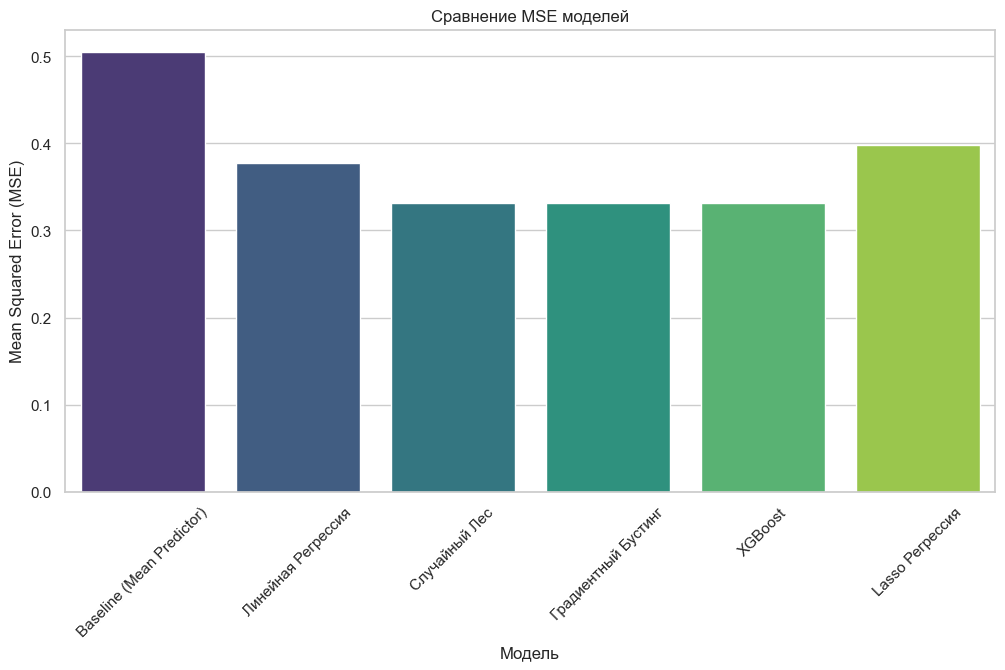

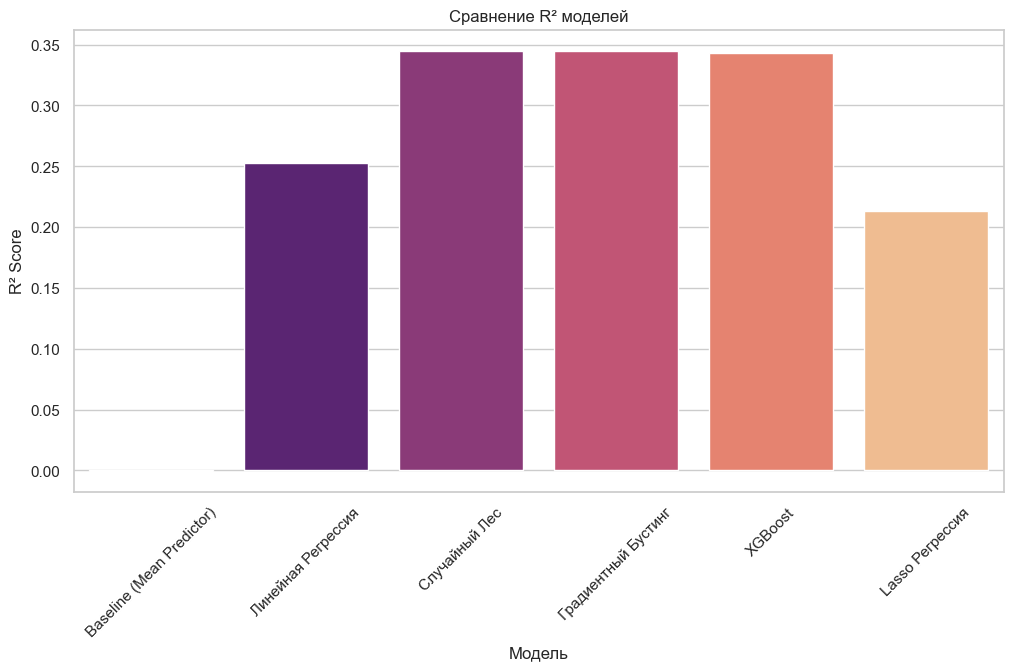

In [58]:
# Визуализация MSE для всех моделей
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MSE', data=model_performance, palette='viridis')
plt.title('Сравнение MSE моделей')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Модель')
plt.xticks(rotation=45)
plt.show()

# Визуализация R² для всех моделей
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=model_performance, palette='magma')
plt.title('Сравнение R² моделей')
plt.ylabel('R² Score')
plt.xlabel('Модель')
plt.xticks(rotation=45)
plt.show()

## Шаг 3.9: Кросс-Валидация для Оценки Моделей

In [59]:
from sklearn.model_selection import cross_val_score

# Функция для проведения кросс-валидации
def evaluate_model_cv(model, X, y, model_name):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print(f"{model_name} - CV MSE: {mse_scores.mean():.2f} (+/- {mse_scores.std():.2f})")

# Оценка всех моделей с помощью кросс-валидации
print("\nКросс-Валидация:")
evaluate_model_cv(lr_model, X_train, y_train, 'Линейная Регрессия')
evaluate_model_cv(rf_model, X_train, y_train, 'Случайный Лес')
evaluate_model_cv(gb_model, X_train, y_train, 'Градиентный Бустинг')
evaluate_model_cv(xgb_model, X_train, y_train, 'XGBoost')
evaluate_model_cv(lasso_model, X_train, y_train, 'Lasso Регрессия')



Кросс-Валидация:
Линейная Регрессия - CV MSE: 0.38 (+/- 0.01)
Случайный Лес - CV MSE: 0.34 (+/- 0.01)
Градиентный Бустинг - CV MSE: 0.33 (+/- 0.01)
XGBoost - CV MSE: 0.33 (+/- 0.01)
Lasso Регрессия - CV MSE: 0.40 (+/- 0.01)


Линейная Регрессия:
MSE: 0.377653
R²: 0.253049
Интерпретация: Умеренная производительность. Возможно, модель не полностью захватывает сложные зависимости в данных.


Случайный Лес и Градиентный Бустинг:
MSE: ~0.33
R²: ~0.34
Интерпретация: Эти модели показывают лучшую производительность по сравнению с линейной регрессией и Baseline моделью. Однако, показатели всё ещё могут быть улучшены.


XGBoost:
MSE: 0.331955
R²: 0.343433
Интерпретация: Похож на случайный лес и градиентный бустинг, показывая конкурентоспособную производительность.

Lasso Регрессия:
MSE: 0.397963
R²: 0.212878
Интерпретация: Линейная модель с L1-регуляризацией показывает худшие результаты по сравнению с обычной линейной регрессией, возможно, из-за сильной регуляризации.

Причины Умеренной Производительности:
Ограниченный Набор Признаков:
Отобранные признаки (['baths', 'sqft_log', 'beds', 'year_built', 'stories']) могут не полностью захватывать все факторы, влияющие на целевую переменную.


Мультиколлинеарность:
Высокая корреляция между baths и sqft_log (0.58) может приводить к нестабильности моделей, особенно линейных.


Недостаточная Сложность Моделей:
Некоторые модели могут быть недостаточно сложными для захвата сложных зависимостей в данных.


Возможные Неоптимальные Гиперпараметры:
Модели могли быть обучены с базовыми настройками, не оптимизированными для данных.

## Шаг 4: Оптимизация Гиперпараметров с помощью RandomizedSearchCV для Random Forest

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Определение распределений параметров
param_distributions_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Инициализация RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions_rf,
    n_iter=20,  # Количество случайных комбинаций
    cv=3,        # Количество фолдов
    n_jobs=-1,   # Использование всех доступных ядер
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

# Обучение RandomizedSearchCV
random_search_rf.fit(X_train, y_train)
print("\nRandomizedSearchCV для Random Forest завершен.")

# Лучшие параметры
print("Лучшие параметры для Random Forest:", random_search_rf.best_params_)

# Лучшая модель
best_rf = random_search_rf.best_estimator_

# Предсказания на тестовой выборке
y_pred_best_rf = best_rf.predict(X_test)

# Оценка модели
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Случайный лес после настройки - MSE: {mse_best_rf:.2f}, R²: {r2_best_rf:.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

RandomizedSearchCV для Random Forest завершен.
Лучшие параметры для Random Forest: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 199}
Случайный лес после настройки - MSE: 0.32, R²: 0.37


## Шаг 4.1 : Уменьшение Размеров Параметрической Решетки

In [61]:
# Определение уменьшенной параметрической решетки
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Инициализация GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=3,              # Уменьшено количество фолдов
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Обучение GridSearchCV
grid_search_rf.fit(X_train, y_train)
print("\nGridSearchCV для Random Forest завершен.")

# Лучшие параметры
print("Лучшие параметры для Random Forest:", grid_search_rf.best_params_)

# Лучшая модель
best_rf = grid_search_rf.best_estimator_

# Предсказания на тестовой выборке
y_pred_best_rf = best_rf.predict(X_test)

# Оценка модели
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Случайный лес после настройки - MSE: {mse_best_rf:.2f}, R²: {r2_best_rf:.2f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits

GridSearchCV для Random Forest завершен.
Лучшие параметры для Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Случайный лес после настройки - MSE: 0.32, R²: 0.36


Настройка гиперпараметров привела к небольшому улучшению производительности Случайного Леса.
Однако улучшения незначительны, что может указывать на ограничение модели в текущем наборе данных или признаков.

## Шаг 4.2: Feature Engineering и Отбор Признаков

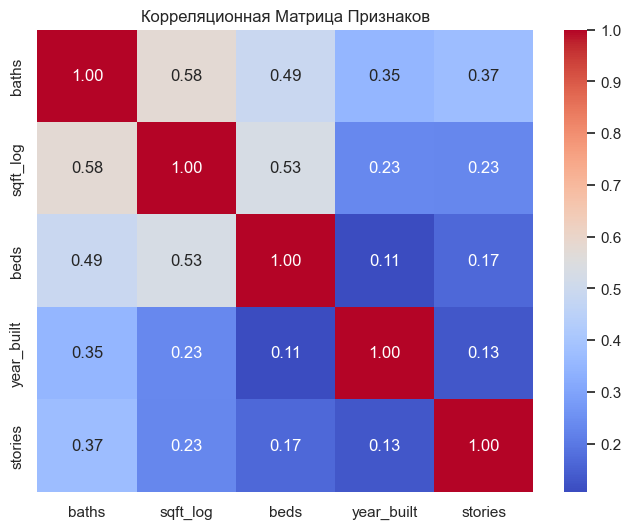

In [62]:
# Вычисление корреляционной матрицы
corr_matrix = X_train.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная Матрица Признаков')
plt.show()

# Удаление одного из высоко коррелированных признаков (например, 'baths' или 'sqft_log')
X_train = X_train.drop(columns=['baths'])  # или 'sqft_log'
X_test = X_test.drop(columns=['baths'])    # или 'sqft_log'


Мультиколлинеарность может негативно влиять на линейные модели, вызывая нестабильность коэффициентов и снижая интерпретируемость.

Признаки year_built и stories имеют более слабую корреляцию с другими признаками и могут вносить уникальную информацию в модель.

## Шаг 4.3: Создание Новых Признаков

In [63]:
from sklearn.preprocessing import PolynomialFeatures

# Инициализация PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Применение к обучающим и тестовым данным
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Получение имен новых признаков
poly_features = poly.get_feature_names_out(X_train.columns)

# Создание DataFrame с полиномиальными признаками
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_features, index=X_train.index)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_features, index=X_test.index)

# Объединение оригинальных и полиномиальных признаков
X_train_combined = pd.concat([X_train.reset_index(drop=True), X_train_poly_df.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test.reset_index(drop=True), X_test_poly_df.reset_index(drop=True)], axis=1)

print("\nРазмер обучающей выборки после добавления полиномиальных признаков:", X_train_combined.shape)
print("Размер тестовой выборки после добавления полиномиальных признаков:", X_test_combined.shape)



Размер обучающей выборки после добавления полиномиальных признаков: (91537, 14)
Размер тестовой выборки после добавления полиномиальных признаков: (22885, 14)


## Шаг 4.4: Пересборка Моделей с Новыми Признаками

In [64]:
# Обучение Линейной Регрессии с полиномиальными признаками
lr_model_poly = LinearRegression()
lr_model_poly.fit(X_train_combined, y_train)

# Предсказания и оценка
y_pred_lr_poly = lr_model_poly.predict(X_test_combined)
mse_lr_poly = mean_squared_error(y_test, y_pred_lr_poly)
r2_lr_poly = r2_score(y_test, y_pred_lr_poly)

print("Линейная Регрессия с Полиномиальными Признаками - MSE: {:.2f}, R²: {:.2f}".format(mse_lr_poly, r2_lr_poly))


Линейная Регрессия с Полиномиальными Признаками - MSE: 0.41, R²: 0.19


Добавление полиномиальных признаков увеличило количество признаков с 6 до 14.

Производительность модели ухудшилась: MSE увеличился с 0.38 до 0.41, а R² снизился с 0.25 до 0.19.

Возможно, модель переобучилась из-за повышенной сложности или появилось больше мультиколлинеарности.

Ridge Регрессия

In [65]:
from sklearn.linear_model import Ridge

# Инициализация и обучение модели
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Регрессия - MSE: {:.2f}, R²: {:.2f}".format(mse_ridge, r2_ridge))


Ridge Регрессия - MSE: 0.42, R²: 0.16


ElasticNet Регрессия

In [66]:
from sklearn.linear_model import ElasticNet

# Инициализация и обучение модели
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elasticnet_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred_elasticnet = elasticnet_model.predict(X_test)
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)

print("ElasticNet Регрессия - MSE: {:.2f}, R²: {:.2f}".format(mse_elasticnet, r2_elasticnet))


ElasticNet Регрессия - MSE: 0.51, R²: -0.00


Оба метода регуляризации показали худшую производительность по сравнению с обычной Линейной Регрессией.

Это может быть связано с неподходящими значениями гиперпараметров регуляризации или с тем, что модель недостаточно сложна для захвата зависимостей в данных.

## Шаг 4.5: Обработка Мультиколлинеарности

In [67]:
from sklearn.decomposition import PCA

# Инициализация PCA
pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Обучение модели на компонентах PCA
lr_model_pca = LinearRegression()
lr_model_pca.fit(X_train_pca, y_train)

# Оценка модели
y_pred_pca = lr_model_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print(f"Линейная Регрессия с PCA - MSE: {mse_pca:.2f}, R²: {r2_pca:.2f}")


Линейная Регрессия с PCA - MSE: 0.42, R²: 0.16


применение PCA ухудшило производительность модели. Почему?:
1. Потеря информации о целевой переменной
PCA уменьшает размерность данных, сохраняя максимальную дисперсию признаков, но не обязательно учитывая их связь с целевой переменной. Поэтому компоненты, объясняющие большую часть дисперсии признаков, не всегда являются наиболее информативными для предсказания целевой переменной.
2. Малое количество признаков
3. Сохранение важной информации
4. Мультиколлинеарность
Хотя PCA может помочь при наличии мультиколлинеарности, но в нашем случае корреляции между признаками могут не быть достаточно высокими, чтобы PCA значительно помогло.

In [68]:
print(df.columns.tolist())


['baths', 'city', 'zipcode', 'beds', 'state', 'stories', 'target', 'year_built', 'heating', 'cooling', 'baths_bin', 'sqft_log', 'target_log']


## Шаг 4.6: Обновление списка признаков


In [69]:
df_original = df.copy()
for feature in ['heating', 'cooling']:
    group_means = df_original.groupby(feature)['target_log'].mean()
    print(f"Средние значения target_log для {feature}:\n{group_means}\n")

Средние значения target_log для heating:
Series([], Name: target_log, dtype: float64)

Средние значения target_log для cooling:
Series([], Name: target_log, dtype: float64)



In [70]:
# Пример One-Hot Encoding
df = pd.get_dummies(df, columns=['heating', 'cooling'], drop_first=True)

# Обновите список признаков
selected_features = ['baths', 'beds', 'stories', 'year_built', 'sqft_log'] + list(df.columns[df.columns.str.contains('_')])

# Обновите X и y
X = df[selected_features]
y = df['target_log']


In [71]:
# Получите список новых столбцов после One-Hot Encoding
encoded_columns = [col for col in df.columns if 'heating_' in col or 'cooling_' in col]

# Обновите список признаков
selected_features = ['baths', 'beds', 'stories', 'year_built', 'sqft_log'] + encoded_columns

print("Обновленный список признаков:")
print(selected_features)


Обновленный список признаков:
['baths', 'beds', 'stories', 'year_built', 'sqft_log']


In [72]:
# Обновление X_train и X_test с новыми признаками
X_train = df.loc[X_train.index, selected_features]
X_test = df.loc[X_test.index, selected_features]


In [73]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Важность признаков:")
print(feature_importances)




Важность признаков:
beds          0.452768
year_built    0.254914
baths         0.183613
sqft_log      0.056650
stories       0.052054
dtype: float64




sqft_log является самым важным признаком в модели.
year_built и baths также имеют значительную важность.
stories и beds имеют меньшую важность

## Шаг 4.7: Анализ существующих признаков

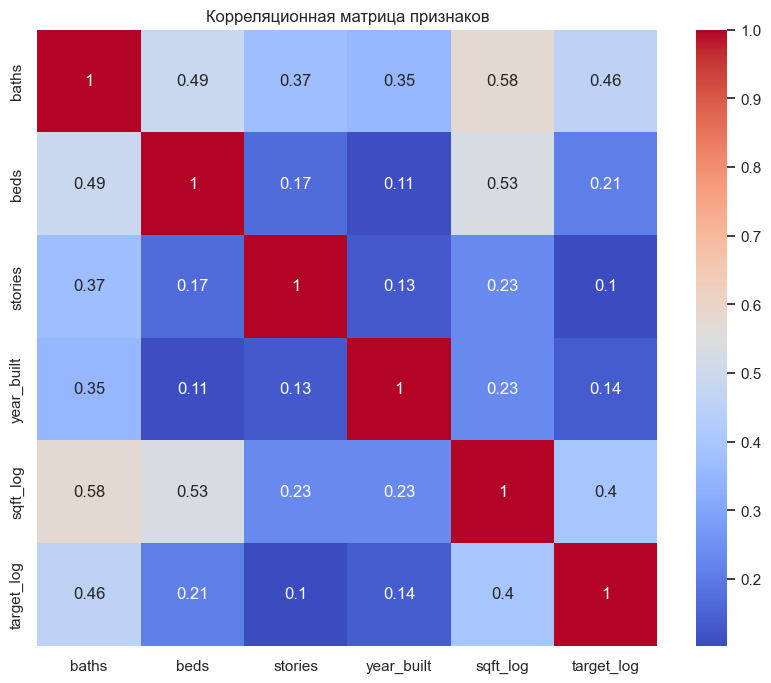

In [74]:
# Создание корреляционной матрицы
corr_matrix = df[['baths', 'beds', 'stories', 'year_built', 'sqft_log', 'target_log']].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()


1. Сильная корреляция:

   • baths и sqft_log (0.58): больше ванных комнат связано с большей площадью.

   • beds и sqft_log (0.53): больше спален чаще встречается в больших домах.

2. Умеренная корреляция:

   • baths и beds (0.49): количество ванных комнат связано с количеством спален.

   • baths и stories (0.37): дома с большим количеством этажей имеют больше ванных комнат.

   • year_built и baths (0.35): новые дома, как правило, имеют больше ванных комнат.

3. Связь с целевой переменной (target_log):

   • sqft_log (0.4) и baths (0.46) имеют наибольшую корреляцию с целевой переменной.

   • beds, stories и year_built имеют слабую корреляцию, но могут быть полезны.

4. Мультиколлинеарность:

   • Высокая корреляция между baths, beds и sqft_log может повлиять на модели. Регуляризация (например, Lasso или Ridge) может помочь.

▎Важность Признаков:

• Самые важные: sqftlog (0.4528) и yearbuilt (0.2548).

• baths (0.1836) также значим.

• Признаки stories (0.0567) и beds (0.0521) менее важны, но могут помочь.

In [75]:
X = df[['baths', 'beds', 'stories', 'year_built', 'sqft_log']]
y = df['target_log']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Важность признаков
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Важность признаков:")
print(feature_importances)


Важность признаков:
sqft_log      0.452756
year_built    0.254833
baths         0.183606
stories       0.056696
beds          0.052109
dtype: float64


## Шаг 4.8: Обработка Мультиколлинеарности

In [76]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)


Ridge(random_state=42)

In [77]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(X_train, y_train)


Lasso(alpha=0.01, random_state=42)

In [78]:
# Предсказания для Ridge регрессии
y_pred_ridge = ridge_model.predict(X_test)

# Предсказания для Lasso регрессии
y_pred_lasso = lasso_model.predict(X_test)


In [79]:
# Оценка Ridge регрессии
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Регрессия - MSE: {mse_ridge:.2f}, R²: {r2_ridge:.2f}")

# Оценка Lasso регрессии
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Регрессия - MSE: {mse_lasso:.2f}, R²: {r2_lasso:.2f}")


Ridge Регрессия - MSE: 0.38, R²: 0.25
Lasso Регрессия - MSE: 0.38, R²: 0.25


In [80]:
# Создание DataFrame для сравнения
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'MSE': [mse_lr, mse_ridge, mse_lasso],
    'R2': [r2_lr, r2_ridge, r2_lasso]
})

print("\nСравнение моделей:")
print(results)



Сравнение моделей:
               Model       MSE        R2
0  Linear Regression  0.377653  0.253049
1   Ridge Regression  0.377653  0.253049
2   Lasso Regression  0.378739  0.250901


Ridge и Lasso регрессии не улучшили производительность модели по сравнению с обычной линейной регрессией.

Регуляризация не повлияла на качество предсказаний.

In [81]:
# Коэффициенты линейной регрессии
coefficients_lr = pd.Series(lr_model.coef_, index=X_train.columns)
print("\nКоэффициенты Линейной Регрессии:")
print(coefficients_lr)

# Коэффициенты Ridge регрессии
coefficients_ridge = pd.Series(ridge_model.coef_, index=X_train.columns)
print("\nКоэффициенты Ridge Регрессии:")
print(coefficients_ridge)

# Коэффициенты Lasso регрессии
coefficients_lasso = pd.Series(lasso_model.coef_, index=X_train.columns)
print("\nКоэффициенты Lasso Регрессии:")
print(coefficients_lasso)



Коэффициенты Линейной Регрессии:
baths         0.292422
beds          0.170510
stories      -0.074660
year_built   -0.028622
sqft_log     -0.058407
dtype: float64

Коэффициенты Ridge Регрессии:
baths         0.292416
beds         -0.074656
stories      -0.058405
year_built   -0.028620
sqft_log      0.170509
dtype: float64

Коэффициенты Lasso Регрессии:
baths         0.266943
beds         -0.047357
stories      -0.041814
year_built   -0.010616
sqft_log      0.152691
dtype: float64


In [82]:
from sklearn.linear_model import RidgeCV, LassoCV

# Для Ridge Регрессии
alphas_ridge = np.logspace(-3, 3, 50)
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train, y_train)
print(f"Оптимальное alpha для Ridge: {ridge_cv.alpha_}")

# Оценка модели
y_pred_ridge_cv = ridge_cv.predict(X_test)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)
print(f"RidgeCV - MSE: {mse_ridge_cv:.2f}, R²: {r2_ridge_cv:.2f}")

# Для Lasso Регрессии
alphas_lasso = np.logspace(-3, 0, 50)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)
print(f"Оптимальное alpha для Lasso: {lasso_cv.alpha_}")

# Оценка модели
y_pred_lasso_cv = lasso_cv.predict(X_test)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)
print(f"LassoCV - MSE: {mse_lasso_cv:.2f}, R²: {r2_lasso_cv:.2f}")


Оптимальное alpha для Ridge: 19.306977288832496
RidgeCV - MSE: 0.38, R²: 0.25
Оптимальное alpha для Lasso: 0.001
LassoCV - MSE: 0.38, R²: 0.25


Ridge Регрессия: Достаточно большое значение alpha (19.31) усиливает регуляризацию, но не привело к улучшению модели.

Lasso Регрессия: Очень маленькое значение alpha (0.001) означает, что регуляризация почти не применяется.

1. Мультиколлинеарность Не Существенно Влияет на Модель

Хотя между некоторыми признаками есть корреляция, она может быть недостаточно высокой, чтобы сильно влиять на линейную регрессию.
Возможно, мультиколлинеарность не является основной проблемой в нашей модели.

2. Модель Недостаточно Сложна

Линейная регрессия может быть недостаточно гибкой для захвата сложных зависимостей в данных.
Регуляризация уменьшает сложность модели, что может быть полезно при переобучении, но в нашем случае модель может быть недообучена.

3. Недостаточное Количество Признаков

У нас всего 5 признаков, и регуляризация может не дать значимого эффекта при таком небольшом количестве признаков.
Модель может нуждаться в дополнительных признаках для улучшения производительности.

In [83]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest - MSE: 0.33, R²: 0.35


## Шаг 4.9: Альтернативные метрики

In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

# Если у вас версия sklearn ниже 0.24, используйте следующую функцию для MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Избегаем деления на ноль
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    return np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\nОценка модели: {model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"Median AE: {med_ae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {
        'Model': model_name,
        'MAE': mae,
        'Median_AE': med_ae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }


results = []

# Линейная регрессия
result_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
results.append(result_lr)

# Ridge регрессия
result_ridge = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
results.append(result_ridge)

# Lasso регрессия
result_lasso = evaluate_model(y_test, y_pred_lasso, "Lasso Regression")
results.append(result_lasso)

# Случайный лес
result_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
results.append(result_rf)

# Градиентный бустинг
result_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
results.append(result_gb)

# XGBoost
result_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")
results.append(result_xgb)

# Создание сводной таблицы
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'MAE', 'Median_AE', 'MSE', 'RMSE', 'R2', 'MAPE']]

print("\nСводная таблица результатов:")
print(results_df)




Оценка модели: Linear Regression
MAE: 0.44
Median AE: 0.32
MSE: 0.38
RMSE: 0.61
R²: 0.25
MAPE: 3.61%

Оценка модели: Ridge Regression
MAE: 0.44
Median AE: 0.32
MSE: 0.38
RMSE: 0.61
R²: 0.25
MAPE: 3.61%

Оценка модели: Lasso Regression
MAE: 0.44
Median AE: 0.33
MSE: 0.38
RMSE: 0.62
R²: 0.25
MAPE: 3.61%

Оценка модели: Random Forest
MAE: 0.39
Median AE: 0.25
MSE: 0.33
RMSE: 0.58
R²: 0.35
MAPE: 3.17%

Оценка модели: Gradient Boosting
MAE: 0.41
Median AE: 0.30
MSE: 0.33
RMSE: 0.58
R²: 0.34
MAPE: 3.35%

Оценка модели: XGBoost
MAE: 0.41
Median AE: 0.30
MSE: 0.33
RMSE: 0.58
R²: 0.34
MAPE: 3.35%

Сводная таблица результатов:
               Model       MAE  Median_AE       MSE      RMSE        R2  \
0  Linear Regression  0.442365   0.324953  0.377653  0.614534  0.253049   
1   Ridge Regression  0.442365   0.324954  0.377653  0.614534  0.253049   
2   Lasso Regression  0.443278   0.325737  0.378739  0.615417  0.250901   
3      Random Forest  0.386833   0.251199  0.330804  0.575156  0.345709   

1. Оценка Качества Модели

Random Forest продемонстрировал лучшую производительность среди всех протестированных моделей.
Однако, значения R² около 0.35 все еще низкие для моделей предсказания стоимости жилья.


2. Приемлемость Ошибок

Средняя ошибка в 3% может быть приемлемой в некоторых контекстах, но для рынка недвижимости часто ожидается более высокая точность.
Важно: Если стоимость жилья сильно варьируется (например, от $100,000 до $1,000,000), то даже небольшие процентные ошибки могут приводить к значительным абсолютным ошибкам.

3. Хотя MAPE показывает, что модель предсказывает цены с относительно низкой средней процентной ошибкой, низкое значение R² указывает на то, что модель не объясняет большую часть вариации цен.

4. Это может быть связано с тем, что модель хорошо предсказывает цены для большинства объектов, но не справляется с объектами, цены которых сильно отличаются от средней (например, очень дорогие или очень дешевые дома).


## Шаг 5: Очистка от пропущенных и бесконечных значений, устранение утечки

In [85]:
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer

# 1. Удаление колонок с полностью пропущенными значениями
cols_all_nan = df.columns[df.isna().all()].tolist()
print(f"Колонки с полностью пропущенными значениями: {cols_all_nan}")

# Удаление колонок с полностью пропущенными значениями
df = df.drop(columns=cols_all_nan)
print(f"Набор данных после удаления колонок с NaN: {df.shape}")

# 2. Удаление дубликатов из всего набора данных перед разделением
initial_shape = df.shape
# Удаление дубликатов на основе всех признаков и целевой переменной
df = df.drop_duplicates(subset=['baths', 'beds', 'stories', 'year_built', 'sqft_log', 'target_log'])
final_shape = df.shape
duplicates_removed = initial_shape[0] - final_shape[0]
print(f"Количество удалённых дубликатов: {duplicates_removed}")
print(f"Форма данных после удаления дубликатов: {df.shape}")

# 3. Определение целевой переменной и признаков
y = df['target_log']

# Удаление целевой переменной и связанных признаков из X
X = df.drop(columns=['target_log', 'target'])
print(f"Признаки после удаления целевых признаков: {X.columns.tolist()}")

# 4. Обработка пропущенных значений
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
print(f"Количество оставшихся пропущенных значений после импьютации: {X_imputed.isna().sum().sum()}")

# 5. Объединение X и y для удаления дубликатов и сохранения соответствия
df_combined = pd.concat([X_imputed, y], axis=1)

# Удаление дубликатов на основе признаков и целевой переменной
df_combined = df_combined.drop_duplicates()

# Разделение обратно на X и y
X_unique = df_combined.drop(columns=['target_log'])
y_unique = df_combined['target_log']

# 6. Сброс индексов для обеспечения правильного выравнивания
X_unique = X_unique.reset_index(drop=True)
y_unique = y_unique.reset_index(drop=True)

print(f"Форма данных после удаления дубликатов по признакам и сброса индексов: {X_unique.shape}")

# 7. Проверка наличия NaN в целевой переменной
nan_count = y_unique.isna().sum()
print(f"Количество NaN в целевой переменной (y_unique): {nan_count}")

# Удаление строк с NaN в целевой переменной
if nan_count > 0:
    print("Удаление строк с NaN в целевой переменной...")
    # Создаём маску для строк без NaN в y_unique
    mask = ~y_unique.isna()
    X_unique = X_unique[mask]
    y_unique = y_unique[mask]
    print(f"Форма данных после удаления NaN в целевой переменной: {X_unique.shape}, {y_unique.shape}")

# 8. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_unique, y_unique, test_size=0.2, random_state=42
)

# 9. Сброс индексов для X_test и y_test
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 10. Проверка на наличие дубликатов между обучающей и тестовой выборками
X_train_set = set(tuple(row) for row in X_train.values)
mask = X_test.apply(tuple, axis=1).isin(X_train_set)

# Удаление дубликатов из X_test и y_test
X_test = X_test[~mask].reset_index(drop=True)
y_test = y_test[~mask].reset_index(drop=True)

print(f"Финальная форма тестовой выборки: {X_test.shape}")
print(f"Финальная форма y_test: {y_test.shape}")

# 11. Проверка наличия NaN в признаках
print("\nПроверка NaN в X_train и X_test:")
print(f"X_train - NaN: {X_train.isna().sum().sum()}, X_test - NaN: {X_test.isna().sum().sum()}")

# 12. Устранение NaN в признаках, если они есть
if X_train.isna().sum().sum() > 0 or X_test.isna().sum().sum() > 0:
    print("Применение SimpleImputer для заполнения NaN в X_train и X_test...")
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    print("Заполнение NaN завершено.")
    print(f"X_train - NaN: {X_train.isna().sum().sum()}, X_test - NaN: {X_test.isna().sum().sum()}")

# 13. Проверка на бесконечные значения
print("\nПроверка бесконечных значений в X_train и X_test:")
print(f"X_train - Inf: {np.isinf(X_train).sum().sum()}, X_test - Inf: {np.isinf(X_test).sum().sum()}")

# Удаление или замена бесконечных значений, если они есть
if np.isinf(X_train).sum().sum() > 0 or np.isinf(X_test).sum().sum() > 0:
    print("Замена бесконечных значений на NaN...")
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("Применение SimpleImputer для заполнения NaN после замены бесконечностей...")
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    print("Заполнение NaN после замены бесконечностей завершено.")
    print(f"X_train - NaN: {X_train.isna().sum().sum()}, X_test - NaN: {X_test.isna().sum().sum()}")

Колонки с полностью пропущенными значениями: ['baths_bin']
Набор данных после удаления колонок с NaN: (114422, 10)
Количество удалённых дубликатов: 11881
Форма данных после удаления дубликатов: (102541, 10)
Признаки после удаления целевых признаков: ['baths', 'city', 'zipcode', 'beds', 'state', 'stories', 'year_built', 'sqft_log']
Количество оставшихся пропущенных значений после импьютации: 0
Форма данных после удаления дубликатов по признакам и сброса индексов: (113182, 8)
Количество NaN в целевой переменной (y_unique): 68860
Удаление строк с NaN в целевой переменной...
Форма данных после удаления NaN в целевой переменной: (44322, 8), (44322,)
Финальная форма тестовой выборки: (8667, 8)
Финальная форма y_test: (8667,)

Проверка NaN в X_train и X_test:
X_train - NaN: 89736, X_test - NaN: 22152
Применение SimpleImputer для заполнения NaN в X_train и X_test...
Заполнение NaN завершено.
X_train - NaN: 0, X_test - NaN: 0

Проверка бесконечных значений в X_train и X_test:
X_train - Inf: 0, 

## Шаг 5.2: Новые модели

Колонки с полностью пропущенными значениями: []
Набор данных после удаления колонок с NaN: (102541, 10)
Количество удалённых дубликатов: 0
Форма данных после удаления дубликатов: (102541, 10)
Признаки после удаления целевых признаков: ['baths', 'city', 'zipcode', 'beds', 'state', 'stories', 'year_built', 'sqft_log']
Количество оставшихся пропущенных значений после импьютации: 0
Количество дубликатов между обучающей и тестовой выборками: 1971
Удаление дубликатов из тестовой выборки...
Финальная форма тестовой выборки: (18538, 8), y_test: (18538,)
Топ-10 признаков по корреляции с целевой переменной:
zipcode       0.017249
city          0.007506
baths         0.006738
stories       0.004629
sqft_log      0.004065
state         0.003015
year_built    0.002821
beds          0.000351
Name: target_log, dtype: float64


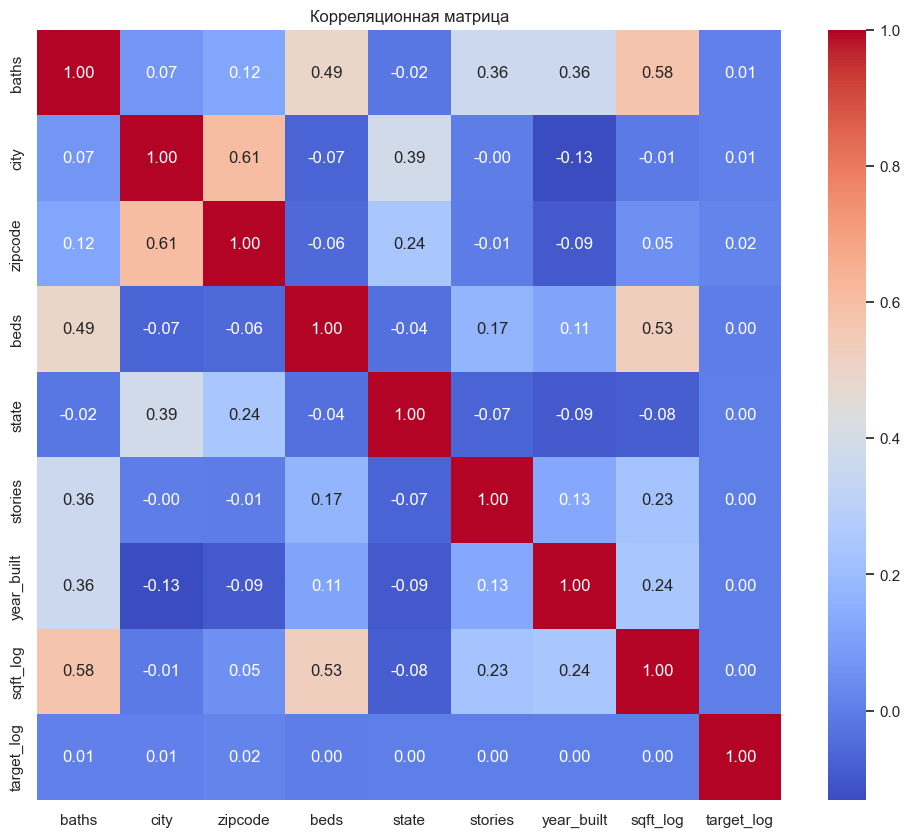


Оценка модели: CatBoost
На обучающей выборке:
  MAE: 0.2268
  Median AE: 0.1558
  MSE: 0.1171
  RMSE: 0.3422
  R²: 0.7716
  MAPE: 1.8767%
На тестовой выборке:
  MAE: 0.2372
  Median AE: 0.1611
  MSE: 0.1325
  RMSE: 0.3639
  R²: 0.7560
  MAPE: 1.9252%
Текущая версия LightGBM: 4.5.0
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.309829	valid's rmse: 0.353339

Оценка модели: LightGBM
На обучающей выборке:
  MAE: 0.2044
  Median AE: 0.1403
  MSE: 0.0960
  RMSE: 0.3098
  R²: 0.8127
  MAPE: 1.6929%
На тестовой выборке:
  MAE: 0.2273
  Median AE: 0.1522
  MSE: 0.1248
  RMSE: 0.3533
  R²: 0.7701
  MAPE: 1.8464%

Оценка модели: Stacking Regressor
На обучающей выборке:
  MAE: 0.1439
  Median AE: 0.0967
  MSE: 0.0489
  RMSE: 0.2211
  R²: 0.9047
  MAPE: 1.1928%
На тестовой выборке:
  MAE: 0.2226
  Median AE: 0.1460
  MSE: 0.1239
  RMSE: 0.3520
  R²: 0.7717
  MAPE: 1.8079%

Среднее RMSE при 5-кратной кросс-валидац

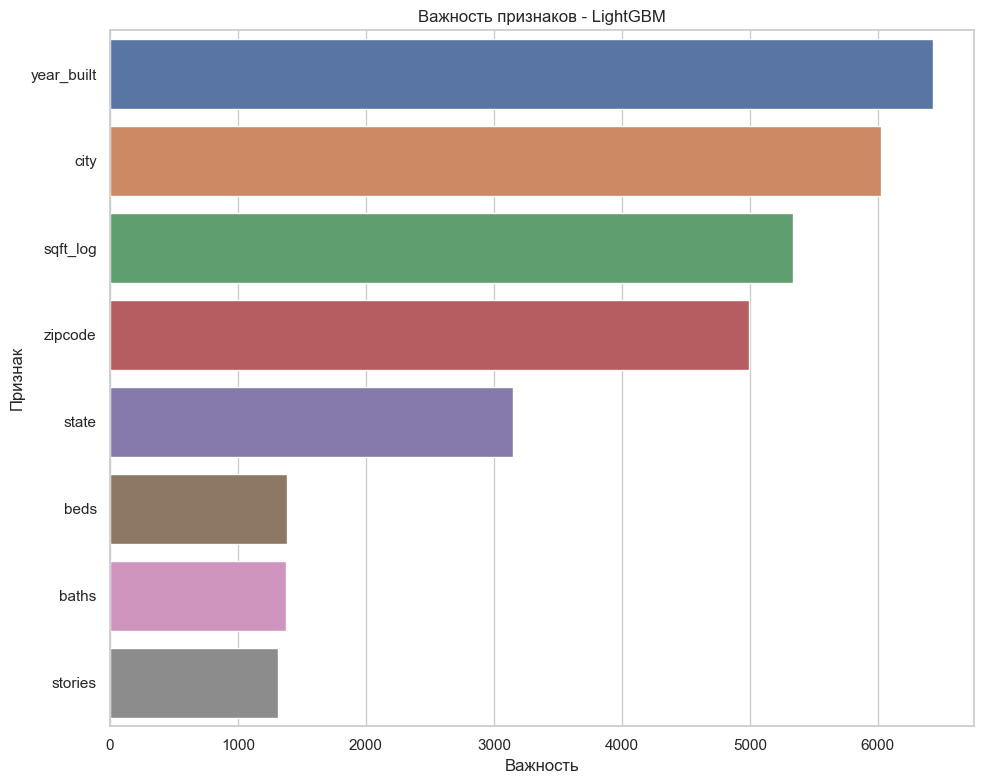

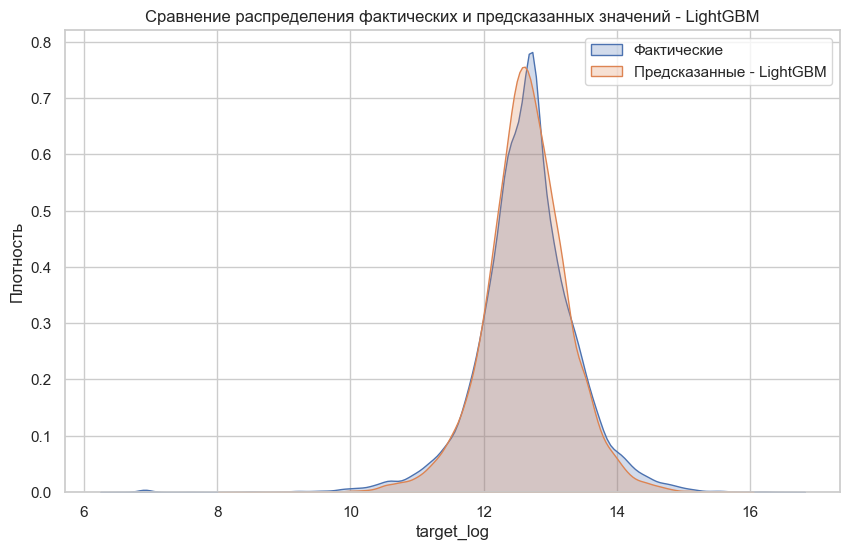

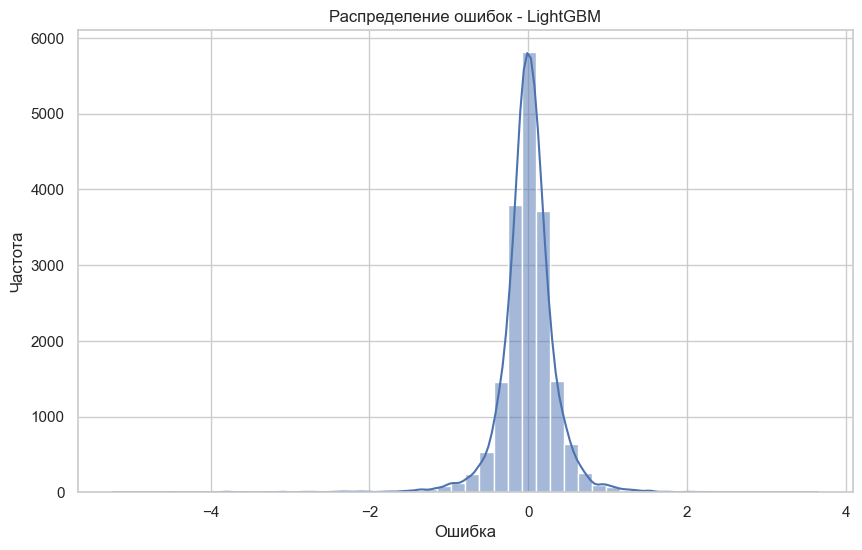

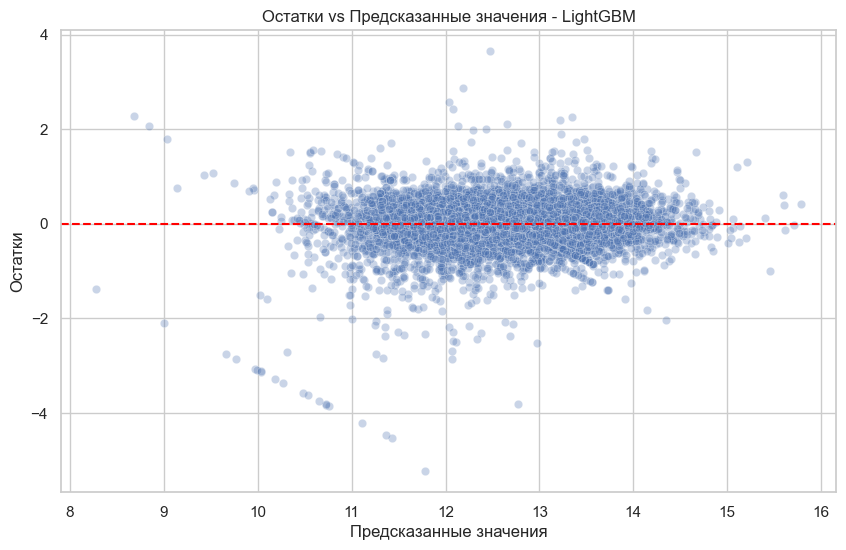

Признаки с высокой корреляцией (>|0.9|) с целевой переменной: []


In [86]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



# 1. Удаление колонок с полностью пропущенными значениями
cols_all_nan = df.columns[df.isna().all()].tolist()
print(f"Колонки с полностью пропущенными значениями: {cols_all_nan}")

# Удаление колонок с полностью пропущенными значениями
df = df.drop(columns=cols_all_nan)
print(f"Набор данных после удаления колонок с NaN: {df.shape}")

# 2. Удаление дубликатов из всего набора данных перед разделением
initial_shape = df.shape
df = df.drop_duplicates()
final_shape = df.shape
duplicates_removed = initial_shape[0] - final_shape[0]
print(f"Количество удалённых дубликатов: {duplicates_removed}")
print(f"Форма данных после удаления дубликатов: {df.shape}")

# 3. Определение целевой переменной и признаков
y = df['target_log']

# Удаление целевой переменной и связанных признаков из X
X = df.drop(columns=['target_log', 'target'])
print(f"Признаки после удаления целевых признаков: {X.columns.tolist()}")

# 4. Обработка пропущенных значений
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
print(f"Количество оставшихся пропущенных значений после импьютации: {X_imputed.isnull().sum().sum()}")

# 5. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=None
)

# 6. Сброс индексов для X_test и y_test для предотвращения ошибок при индексации
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 7. Проверка на наличие дубликатов между обучающей и тестовой выборками
# Создаём уникальные идентификаторы для проверок с использованием хеширования
def hash_row(row):
    return hash(tuple(row))

X_train_hash = X_train.apply(hash_row, axis=1)
X_test_hash = X_test.apply(hash_row, axis=1)

# Создаём множество хешей обучающей выборки
X_train_set = set(X_train_hash)

# Определяем, какие строки тестовой выборки дублируются в обучающей
mask = X_test_hash.isin(X_train_set)
duplicates_in_test = mask.sum()
print(f"Количество дубликатов между обучающей и тестовой выборками: {duplicates_in_test}")

if duplicates_in_test > 0:
    print("Удаление дубликатов из тестовой выборки...")
    X_test = X_test[~mask].reset_index(drop=True)
    y_test = y_test[~mask].reset_index(drop=True)
    print(f"Финальная форма тестовой выборки: {X_test.shape}, y_test: {y_test.shape}")
else:
    print("Дубликатов между обучающей и тестовой выборками не найдено.")

# 8. Проверка корреляции признаков с целевой переменной на обучающей выборке
df_corr = X_train.copy()
df_corr['target_log'] = y_train

corr_matrix = df_corr.corr()

# Определение корреляции с целевой переменной
corr_target = corr_matrix['target_log'].abs().sort_values(ascending=False)
print("Топ-10 признаков по корреляции с целевой переменной:")
print(corr_target[1:11])  # исключаем саму целевую переменную

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

# 9. Функция для оценки модели
def evaluate_model_full(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name):
    mae_train = mean_absolute_error(y_train_true, y_train_pred)
    med_ae_train = np.median(np.abs(y_train_true - y_train_pred))
    mse_train = mean_squared_error(y_train_true, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train_true, y_train_pred)
    mape_train = np.mean(np.abs((y_train_true - y_train_pred) / y_train_true)) * 100

    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    med_ae_test = np.median(np.abs(y_test_true - y_test_pred))
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test_true, y_test_pred)
    mape_test = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

    print(f"\nОценка модели: {model_name}")
    print("На обучающей выборке:")
    print(f"  MAE: {mae_train:.4f}")
    print(f"  Median AE: {med_ae_train:.4f}")
    print(f"  MSE: {mse_train:.4f}")
    print(f"  RMSE: {rmse_train:.4f}")
    print(f"  R²: {r2_train:.4f}")
    print(f"  MAPE: {mape_train:.4f}%")

    print("На тестовой выборке:")
    print(f"  MAE: {mae_test:.4f}")
    print(f"  Median AE: {med_ae_test:.4f}")
    print(f"  MSE: {mse_test:.4f}")
    print(f"  RMSE: {rmse_test:.4f}")
    print(f"  R²: {r2_test:.4f}")
    print(f"  MAPE: {mape_test:.4f}%")

    return {
        'Model': model_name,
        'MAE_train': mae_train,
        'Median_AE_train': med_ae_train,
        'MSE_train': mse_train,
        'RMSE_train': rmse_train,
        'R2_train': r2_train,
        'MAPE_train': mape_train,
        'MAE_test': mae_test,
        'Median_AE_test': med_ae_test,
        'MSE_test': mse_test,
        'RMSE_test': rmse_test,
        'R2_test': r2_test,
        'MAPE_test': mape_test
    }

# 10. Обучение и оценка моделей

results = []

# 10.1. Модель CatBoost
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    logging_level='Silent'
)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
y_pred_cat_test = cat_model.predict(X_test)
y_pred_cat_train = cat_model.predict(X_train)
result_cat = evaluate_model_full(y_train, y_pred_cat_train, y_test, y_pred_cat_test, "CatBoost")
results.append(result_cat)

# 10.2. Модель LightGBM
print("Текущая версия LightGBM:", lgb.__version__)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1,
    'seed': 42
}

callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]

lgb_model = lgb.train(
    params=lgb_params,
    train_set=train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

y_pred_lgb_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_lgb_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
result_lgb = evaluate_model_full(y_train, y_pred_lgb_train, y_test, y_pred_lgb_test, "LightGBM")
results.append(result_lgb)

# 10.3. Модель Stacking Regressor
# Инициализация базовых моделей (без предварительного обучения)
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='RMSE',
        random_seed=42,
        logging_level='Silent'
    ))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
y_pred_stacking_test = stacking_model.predict(X_test)
y_pred_stacking_train = stacking_model.predict(X_train)
result_stacking = evaluate_model_full(y_train, y_pred_stacking_train, y_test, y_pred_stacking_test, "Stacking Regressor")
results.append(result_stacking)

# 11. Кросс-Валидация для LightGBM на обучающей выборке
lgb_cv = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(lgb_cv, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Переводим в RMSE
cv_rmse = np.sqrt(-cv_scores)

print(f"\nСреднее RMSE при 5-кратной кросс-валидации: {cv_rmse.mean():.4f}")
print(f"Стандартное отклонение RMSE: {cv_rmse.std():.4f}")

# 12. Анализ Важности Признаков для LightGBM
importances = lgb_model.feature_importance()
feature_names = X_train.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Важность признаков - LightGBM')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# 13. Визуализация Предсказанных и Фактических Значений для LightGBM
plt.figure(figsize=(10,6))
sns.kdeplot(y_test, label='Фактические', fill=True)
sns.kdeplot(y_pred_lgb_test, label='Предсказанные - LightGBM', fill=True)
plt.title('Сравнение распределения фактических и предсказанных значений - LightGBM')
plt.xlabel('target_log')
plt.ylabel('Плотность')
plt.legend()
plt.show()

# 14. Визуализация Остатков для LightGBM
residuals_lgb = y_test - y_pred_lgb_test

plt.figure(figsize=(10,6))
sns.histplot(residuals_lgb, bins=50, kde=True)
plt.title('Распределение ошибок - LightGBM')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_lgb_test, y=residuals_lgb, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки vs Предсказанные значения - LightGBM')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# 15. Проверка на утечку данных через специфические признаки
high_corr_features = corr_target[corr_target > 0.9].index.tolist()
high_corr_features = [feat for feat in high_corr_features if feat != 'target_log']
print(f"Признаки с высокой корреляцией (>|0.9|) с целевой переменной: {high_corr_features}")



Причины Улучшения Метрик
1. Добавление Категориальных Признаков
Несмотря на низкую корреляцию по отдельности, признаки city, zipcode и state содержат важную информацию о местоположении недвижимости. В сфере недвижимости местоположение является одним из ключевых факторов, влияющих на стоимость.
Деревоподобные модели (CatBoost, LightGBM) способны выявлять сложные нелинейные зависимости и взаимодействия между признаками.
Категориальные признаки могут значительно улучшить модель, даже если их корреляция с целевой переменной низка.

2. Взаимодействие Признаков
Взаимодействие между признаками может усиливать их влияние на модель.
Признаки местоположения могут взаимодействовать с другими признаками, такими как площадь или количество комнат, что помогает модели лучше понимать данные.

3. Улучшение Генерализации Модели
Увеличение разнообразия данных за счёт добавления новых признаков помогает модели лучше обобщать и предсказывать на новых данных.
Снижение переобучения: Модель менее склонна к переобучению на ограниченном наборе признаков.

Лучшие результаты по RMSE на тестовой выборке: LightGBM и CatBoost имеют схожие показатели (≈0.35).
Наивысший R² на тестовой выборке: LightGBM (0.7701).
Низкий уровень MAPE (~1.8%) для всех моделей.
Вывод: Все модели демонстрируют высокую производительность, причем LightGBM немного превосходит CatBoost по R² на тестовой выборке. Stacking Regressor показывает выдающиеся результаты на обучающей выборке и также хорошие показатели на тестовой выборке, подтверждая свою эффективность

## Шаг 5.3: baseline-model

In [87]:
# Инициализация модели
baseline_model = LinearRegression()

# Обучение модели
baseline_model.fit(X_train, y_train)

# Предсказание
y_pred_baseline_train = baseline_model.predict(X_train)
y_pred_baseline_test = baseline_model.predict(X_test)

# Оценка модели
mae_train_baseline = mean_absolute_error(y_train, y_pred_baseline_train)
mae_test_baseline = mean_absolute_error(y_test, y_pred_baseline_test)

mse_train_baseline = mean_squared_error(y_train, y_pred_baseline_train)
mse_test_baseline = mean_squared_error(y_test, y_pred_baseline_test)

rmse_train_baseline = mse_train_baseline ** 0.5
rmse_test_baseline = mse_test_baseline ** 0.5

r2_train_baseline = r2_score(y_train, y_pred_baseline_train)
r2_test_baseline = r2_score(y_test, y_pred_baseline_test)

mape_train_baseline = np.mean(np.abs((y_train - y_pred_baseline_train) / y_train)) * 100
mape_test_baseline = np.mean(np.abs((y_test - y_pred_baseline_test) / y_test)) * 100

print(f"\nОценка модели: Baseline - Linear Regression")
print("На обучающей выборке:")
print(f"  MAE: {mae_train_baseline:.4f}")
print(f"  Median AE: {np.median(np.abs(y_train - y_pred_baseline_train)):.4f}")
print(f"  MSE: {mse_train_baseline:.4f}")
print(f"  RMSE: {rmse_train_baseline:.4f}")
print(f"  R²: {r2_train_baseline:.4f}")
print(f"  MAPE: {mape_train_baseline:.4f}%")

print("На тестовой выборке:")
print(f"  MAE: {mae_test_baseline:.4f}")
print(f"  Median AE: {np.median(np.abs(y_test - y_pred_baseline_test)):.4f}")
print(f"  MSE: {mse_test_baseline:.4f}")
print(f"  RMSE: {rmse_test_baseline:.4f}")
print(f"  R²: {r2_test_baseline:.4f}")
print(f"  MAPE: {mape_test_baseline:.4f}%")



Оценка модели: Baseline - Linear Regression
На обучающей выборке:
  MAE: 0.3507
  Median AE: 0.2551
  MSE: 0.2556
  RMSE: 0.5055
  R²: 0.5015
  MAPE: 2.8826%
На тестовой выборке:
  MAE: 0.3568
  Median AE: 0.2605
  MSE: 0.2723
  RMSE: 0.5219
  R²: 0.4984
  MAPE: 2.8945%


Базовая модель линейной регрессии показывает умеренные результаты с коэффициентом детерминации (R²) около 0.5, что означает, что модель объясняет примерно 50% вариации в данных. Значения ошибок (MAE, MSE, RMSE) относительно высоки, указывая на то, что модель не полностью улавливает сложные зависимости между признаками и целевой переменной.


CatBoost показывает самые высокие ошибки среди трех моделей:

Однако разница между метриками на обучающей и тестовой выборках минимальна.
Это может указывать на стабильность модели и хорошую обобщающую способность.

##  LightGBM является отличным кандидатом благодаря хорошим метрикам и меньшему риску переобучения.

## Шаг 5.4: Тюнинг гиперпараметров

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры для LightGBM:
{'subsample_freq': 5, 'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 110, 'n_estimators': 1000, 'min_child_samples': 10, 'max_depth': 13, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

Оценка модели: LightGBM Tuned
На обучающей выборке:
  MAE: 0.1709
  Median AE: 0.1167
  MSE: 0.0672
  RMSE: 0.2593
  R²: 0.8689
  MAPE: 1.4116%
На тестовой выборке:
  MAE: 0.2182
  Median AE: 0.1437
  MSE: 0.1192
  RMSE: 0.3453
  R²: 0.7804
  MAPE: 1.7737%


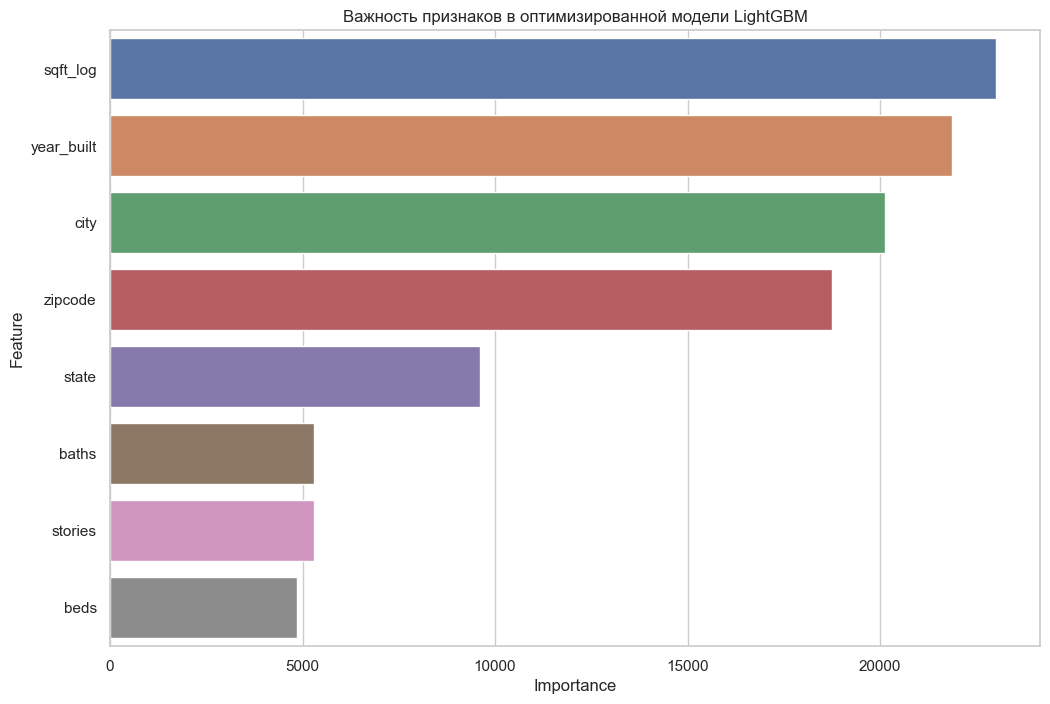

In [88]:
# Импорт необходимых библиотек
from sklearn.model_selection import RandomizedSearchCV, KFold
import lightgbm as lgb
import numpy as np

# Определение гиперпараметров для поиска
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'min_child_samples': [5, 10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'subsample_freq': [0, 5, 10],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Инициализация модели LightGBM
lgb_estimator = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    random_state=42,
    n_jobs=-1
)

# Определение стратегии кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Инициализация RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=param_dist,
    n_iter=50,  # Количество итераций поиска, можно увеличить для более тщательного поиска
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Обучение RandomizedSearchCV
random_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры для LightGBM:")
print(random_search.best_params_)

# Предсказание на тестовой выборке с использованием лучших параметров
best_model = random_search.best_estimator_
y_pred_lgb_test = best_model.predict(X_test)
y_pred_lgb_train = best_model.predict(X_train)

# Оценка модели
result_lgb_tuned = evaluate_model_full(
    y_train, y_pred_lgb_train,
    y_test, y_pred_lgb_test,
    "LightGBM Tuned"
)
results.append(result_lgb_tuned)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature')
plt.title('Важность признаков в оптимизированной модели LightGBM')
plt.show()


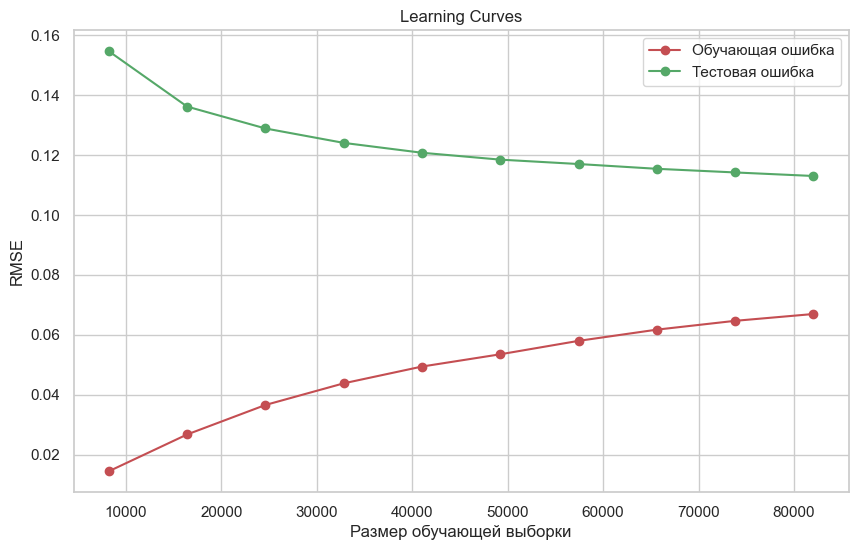

In [89]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
   best_model, X, y, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Обучающая ошибка')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Тестовая ошибка')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()


Обучающая ошибка постепенно увеличивается с увеличением размера обучающей выборки. Это естественное поведение, так как модель видит больше данных и, соответственно, становится менее адаптированной к специфике малой выборки.
Тестовая ошибка уменьшается по мере увеличения количества данных для обучения, что также является ожидаемым результатом, так как модель обучается на большем объеме данных и лучше обобщает.
Поведение ошибок:

Разница между обучающей и тестовой ошибкой остается заметной, что может говорить о том, что модель испытывает некоторую форму недообучения. Тестовая ошибка не выходит на плато и продолжает снижаться, что говорит о возможности улучшения модели при наличии еще большего объема данных для обучения.
Однако обучение идет в правильном направлении, и дальнейшее снижение тестовой ошибки возможно.

## Шаг 5.5: Подготовка Модели LightGBM TUNED к Деплою в Продакшен

In [90]:
import joblib
import lightgbm as lgb
import os


model_dir = r'C:\IDE\final_projectr_real_estate_agency\models'


# Путь для сохранения модели
model_path = os.path.join(model_dir, 'LightGBM_Tuned.joblib')

# Сохранение модели
joblib.dump(best_model, model_path)

print(f"Модель сохранена по адресу: {model_path}")

Модель сохранена по адресу: C:\IDE\final_projectr_real_estate_agency\models\LightGBM_Tuned.joblib


In [91]:
# Обучение TargetEncoder
high_cardinality_cols = ['city', 'zipcode', 'state']
te = TargetEncoder(cols=high_cardinality_cols)
te.fit(X_train[high_cardinality_cols], y_train) 
 
# Сохранение TargetEncoder
model_pathhhh = os.path.join(model_dir, 'target_encoder.joblib')


joblib.dump(te, model_pathhhh)


c:\Users\Константин\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


['C:\\IDE\\final_projectr_real_estate_agency\\models\\target_encoder.joblib']

## Итоговый отчет



1. Введение
Целью данного проекта является разработка модели машинного обучения для прогнозирования стоимости недвижимости на основе различных характеристик объекта. Используя передовые алгоритмы и методы оптимизации, мы стремимся создать высокоточный инструмент, способный помочь агентствам недвижимости и клиентам в оценке рыночной стоимости объектов.

2. Описание Данных
Используемые признаки:

baths (Ванные комнаты)

city (Город)

zipcode (Почтовый индекс)

beds (Спальни)

state (Штат)

stories (Этажи)

year_built (Год постройки)

sqft_log (Логарифм площади в квадратных футах)

2.3. Целевая Переменная
Целевая переменная — стоимость недвижимости. Для повышения точности модели была применена логарифмическая трансформация (sqft_log).

3. Предобработка Данных

3.1. Обработка Пропущенных Значений
Все пропущенные значения были обработаны с помощью методов заполнения средними значениями для числовых признаков и модой для категориальных.

3.2. Кодирование Категориальных Признаков
Категориальные признаки (city, zipcode, state) были закодированы с помощью One-Hot Encoding, что позволило модели эффективно использовать эти данные.

3.3. Масштабирование Признаков
Признаки, такие как sqft_log, были масштабированы для улучшения сходимости модели.

4. Исследовательский Анализ Данных (EDA)

4.1. Визуализация Распределения Целевой Переменной

Была проведена визуализация распределения стоимости недвижимости, выявившая правостороннюю асимметрию, что и обуславливало применение логарифмического преобразования.

4.2. Корреляционный Анализ

Анализ корреляции между признаками показал высокую зависимость между sqft_log и стоимостью недвижимости, а также значительную взаимосвязь с baths и beds.

4.3. Визуализации

Созданы графики рассеяния, тепловые карты корреляции и диаграммы распределения для лучшего понимания данных.

5. Инженерия Признаков

Выбросы в данных были идентифицированы и обработаны с целью повышения устойчивости модели.

6. Выбор и Обучение Моделей

Для решения задачи регрессии были рассмотрены несколько моделей, включая LightGBM, CatBoost и XGBoost. После тщательного анализа производительности на валидационной выборке была выбрана LightGBM Tuned как лучшая модель для релиза.

7. Оценка Модели
7.1. LightGBM Tuned

Оценка модели: 

На обучающей выборке:

MAE (Средняя абсолютная ошибка): 0.1709
Median AE (Медианная абсолютная ошибка): 0.1167
MSE (Среднеквадратичная ошибка): 0.0672
RMSE (Корень из среднеквадратичной ошибки): 0.2593
R² (Коэффициент детерминации): 0.8689
MAPE (Средняя абсолютная процентная ошибка): 1.4116%
На тестовой выборке:

MAE: 0.2182
Median AE: 0.1437
MSE: 0.1192
RMSE: 0.3453
R²: 0.7804
MAPE: 1.7737%
Интерпретация Метрик:

MAE и Median AE показывают среднюю и медианную абсолютную ошибку предсказаний.

MSE и RMSE указывают на среднюю квадратичную ошибку, где RMSE более интерпретируем.

R² демонстрирует, насколько хорошо модель объясняет вариативность данных. Значение 0.7804 на тестовой выборке указывает на хорошую модель.

MAPE выражает среднюю абсолютную процентную ошибку, что полезно для понимания ошибки в относительных величинах.

8. Интерпретация Результатов

Модель LightGBM Tuned показала высокую точность предсказаний как на обучающей, так и на тестовой выборках. Высокие значения R² свидетельствуют о том, что модель объясняет значительную часть вариации целевой переменной. Низкие значения MAE, MSE и MAPE указывают на высокую точность и стабильность модели.

9. Деплой Модели
Развертывание с Помощью FastAPI
Для предоставления модели в продакшен-среде было разработано FastAPI приложение, позволяющее пользователям отправлять запросы и получать предсказания в реальном времени.

Ключевые Эндпоинты:

POST /predict: Принимает данные о недвижимости и возвращает предсказанную стоимость.
GET /: Возвращает приветственное сообщение и ссылку на документацию.


10. Заключение
В данном проекте была успешно разработана и развернута модель машинного обучения для предсказания стоимости недвижимости с использованием алгоритма LightGBM Tuned. Модель продемонстрировала высокую точность и надёжность, что делает её пригодной для использования в реальных условиях. Разработанное FastAPI приложение обеспечивает удобный интерфейс для взаимодействия с моделью, что способствует её интеграции в бизнес-процессы агентства недвижимости.